# Initialization cells
Follows are initialization cells to
- Reset the package directory
- Reload the k-seq package

Some updates need to be done manually:
- If any change made in the object, all inherent objects needs to be reassigned

In [543]:
import sys
import numpy as np
# add package directory to the top of sys.path
if np.sum([dirc.find('k-seq') >= 0 for dirc in sys.path]) == 0:
    sys.path = ['/home/yuning/Work/k-seq/src/'] + sys.path

import util
import importlib
import k_seq.data.pre_processing as pre_processing
import k_seq.data.analysis as analysis
import k_seq.fitting.fitting as fitting
import k_seq.fitting.analysis as fit_analysis
import k_seq.data.io as io
importlib.reload(pre_processing)# refresh data module
importlib.reload(analysis)# refresh data module
importlib.reload(fit_analysis)
importlib.reload(fitting)
importlib.reload(io)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Sequencing sample analysis
## import samples

In [544]:
# read counts files into sample_set
sample_set = pre_processing.load_count_files(
    file_root='/mnt/storage/projects/k-seq/input/bfo_counts/counts',
    pattern='_counts.txt',
    x_values='byo',
    name_pattern='[R4{select_rep}-{byo, digit}{sequence_rep}_S{sample_id, digit}]_counts.txt',
    sort_fn = lambda sample: sample.metadata['sample_id']
)

print('Seqencing samples imported')
# indicate spike-in amount to calculate quantification factors
spike_in_amounts = []
for i in range(4):
    spike_in_amounts += [4130, 1240, 826, 413, 207, 82.6, 41.3]

sample_set = pre_processing.get_quant_factors(
    sample_set=sample_set,
    max_dist=2,
    max_dist_to_survey=10,
    spike_in='AAAAACAAAAACAAAAACAAA',
    spike_in_amounts=spike_in_amounts
)

print('Quantification factors calculated')

NOTICE: no sample_list is given, samples will extract automaticall from file_root.
Seqencing samples imported
Quantification factors calculated


## List sample overview

,sample type,name,total counts,unique sequences,x_value,spike-in amount,spike-in counts (dist=2),spike-in percent,quantification factor
0,input,R4A-inputA_S1,"2,165,970","330,565",NaN,4130.0,416438,0.192,2.148e+04
1,reacted,R4A-1250A_S2,"2,006,578","29,455",1250.0,1240.0,322730,0.161,7.710e+03
2,reacted,R4A-250A_S3,"1,845,900","23,911",250.0,826.0,267257,0.145,5.705e+03
3,reacted,R4A-50A_S4,"2,617,260","43,687",50.0,413.0,453121,0.173,2.386e+03
4,reacted,R4A-10A_S5,"1,515,552","26,410",10.0,207.0,351337,0.232,8.929e+02
5,reacted,R4A-2A_S6,"1,580,503","24,362",2.0,82.6,460933,0.292,2.832e+02
6,reacted,R4A-0A_S7,"2,948,173","2,825",0.0,41.3,2839946,0.963,4.287e+01
7,input,R4A-inputB_S8,"1,257,100","174,225",NaN,4130.0,304332,0.242,1.706e+04
8,reacted,R4A-1250B_S9,"3,451,114","42,691",1250.0,1240.0,601219,0.174,7.118e+03
9,reacted,R4A-250B_S10,"10,273,787","120,423",250.0,826.0,1312643,0.128,6.465e+03


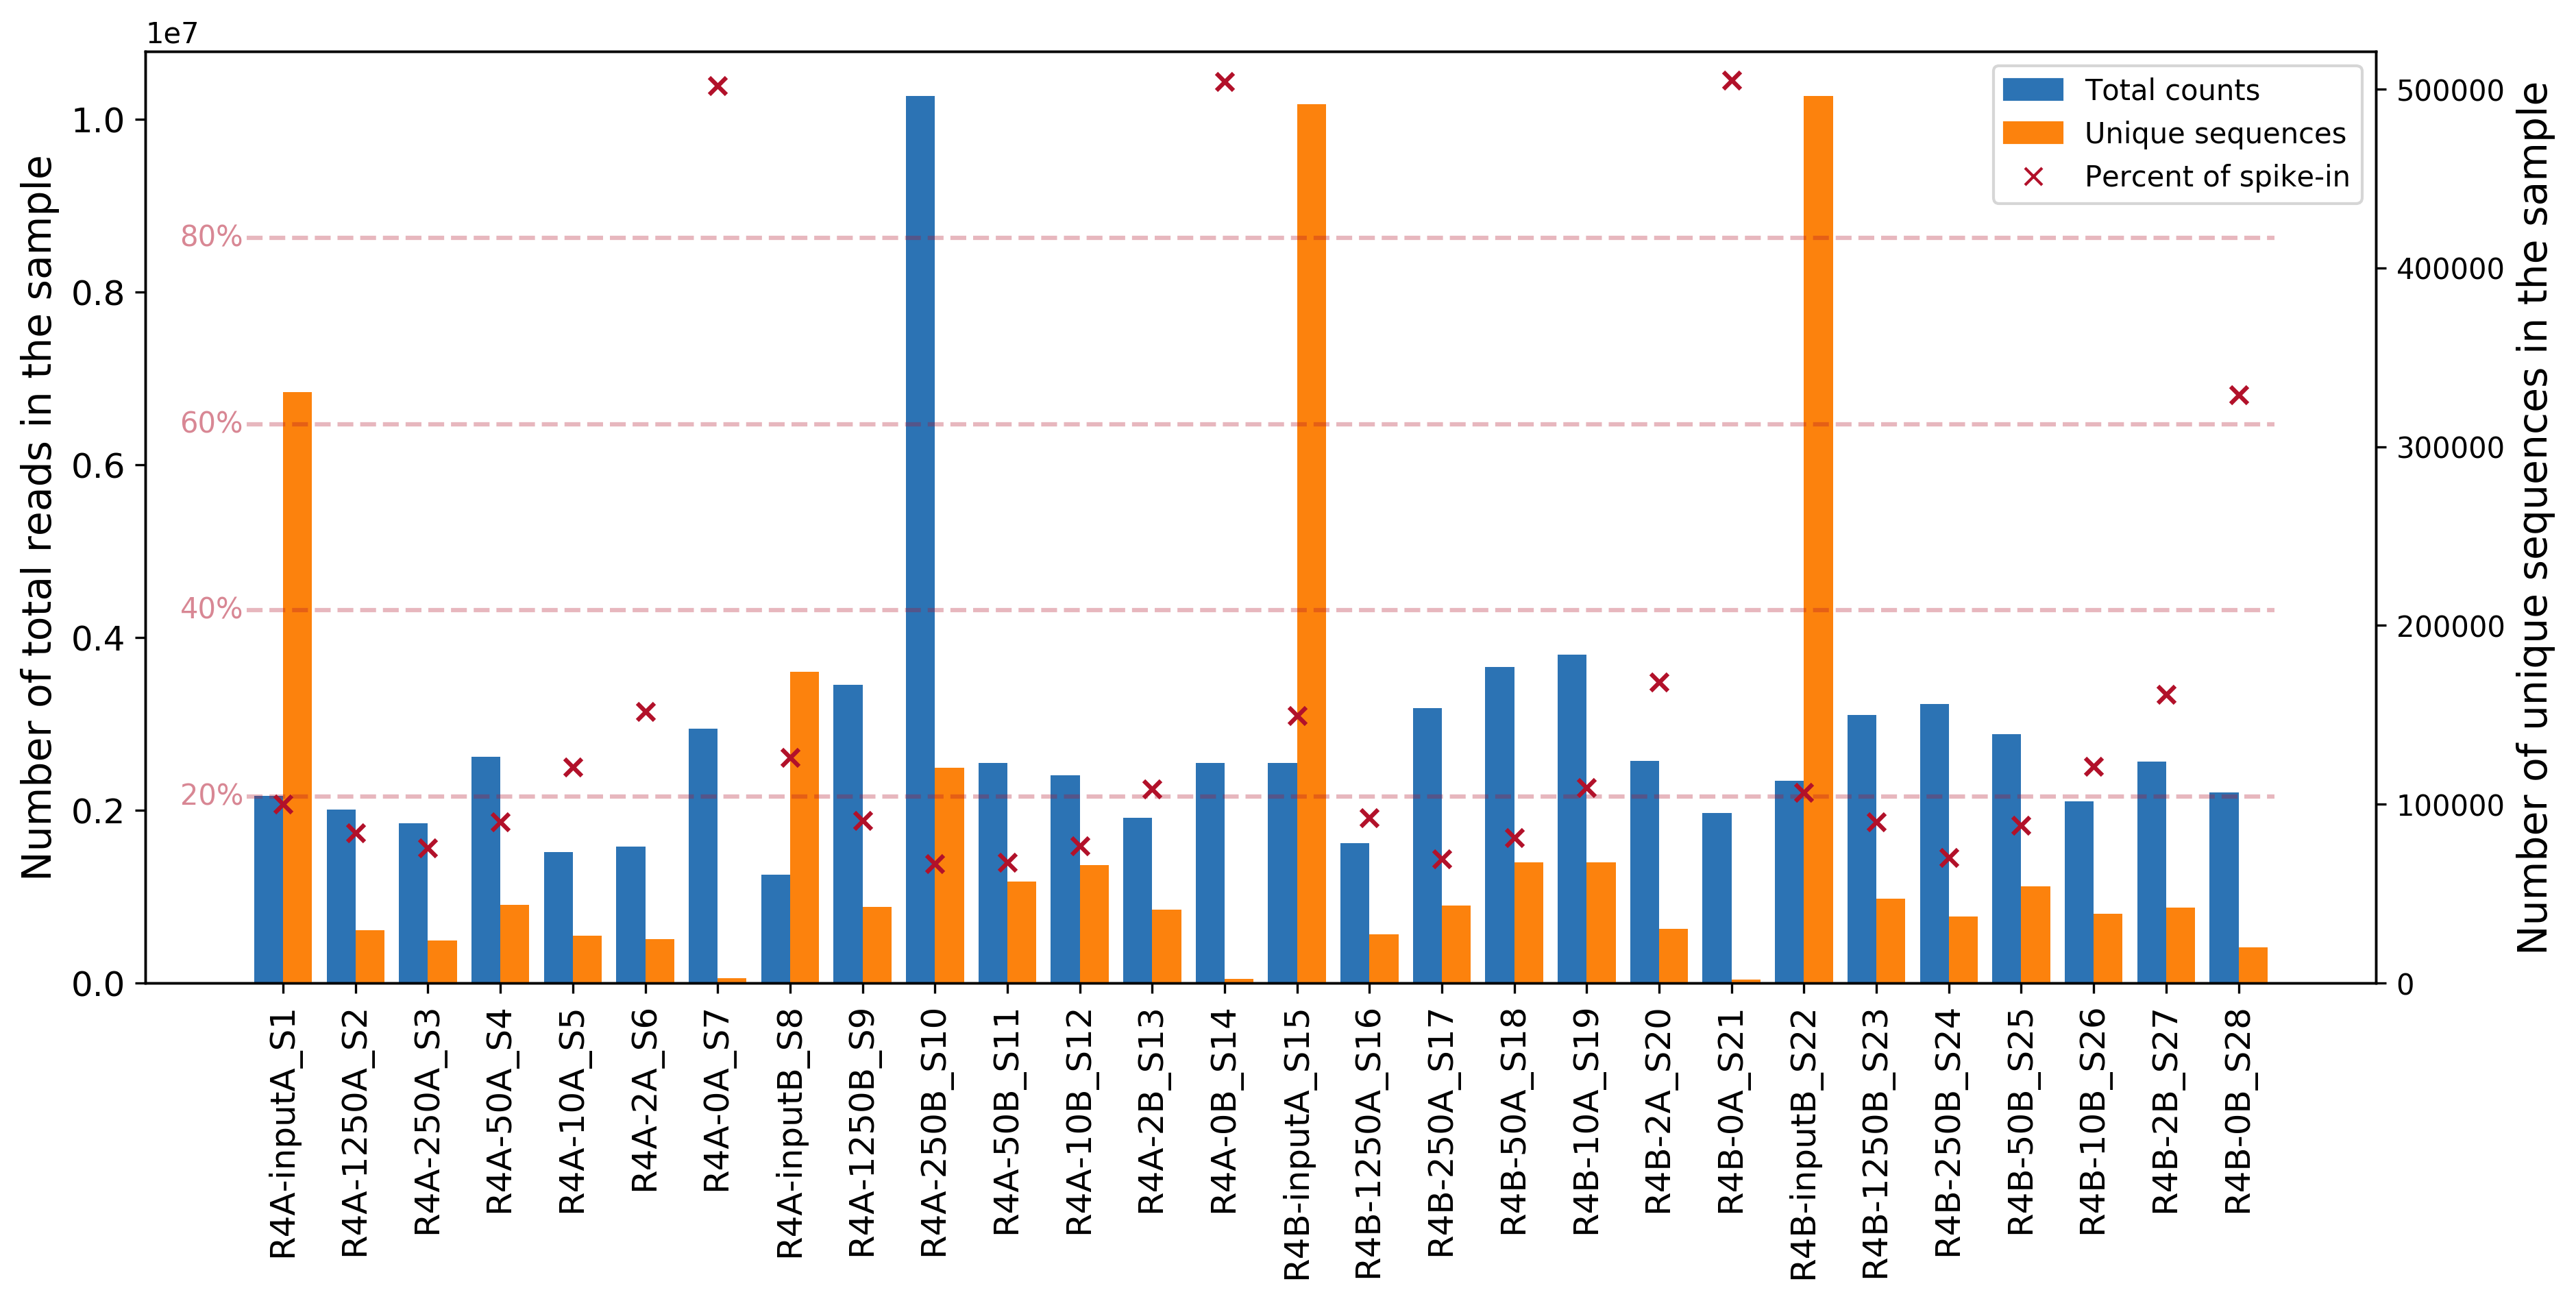

In [31]:
_ = analysis.sequencing_sample_info_table(sample_set)
analysis.sequencing_sample_info_plot(sample_set)

## Following are todos in this section

In [641]:
x = 2
print(x)
x = [x for _ in range(3)]
print(x)

2
[2, 2, 2]


## distribution of spike-in sequence

Check the distance of post-selection pool from **BYO** selection to spike-in


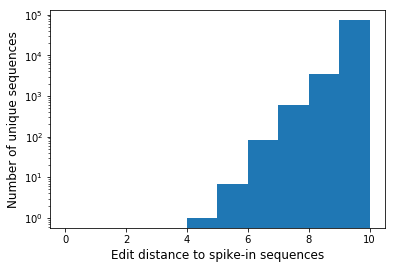

In [42]:
dirc = '/mnt/storage/projects/k-seq/input/byo_counts/R5c-counts.txt'
sample = data.read_count_file(dirc)
import Levenshtein
stdSeq='AAAAACAAAAACAAAAACAAA'
stdPeak = {}
for seq in sample['seqs'].items():
    dist = Levenshtein.distance(seq[0], stdSeq)
    if dist <= 10:
        stdPeak[seq[0]] = {
            'count': seq[1],
            'distance': dist
        }
        
import matplotlib.pyplot as plt
print(util.color.BOLD + util.color.BLUE + \
'Check the distance of post-selection pool from **BYO** selection to spike-in' + util.color.END)

distList = [seq['distance'] for seq in stdPeak.values()]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(distList, bins=np.linspace(0, 10, 11))
ax.set_yscale('log')
ax.set_ylabel('Number of unique sequences', fontsize=12)
ax.set_xlabel('Edit distance to spike-in sequences', fontsize=12)
plt.show()

Distribution of external standard peak


<Figure size 432x288 with 0 Axes>

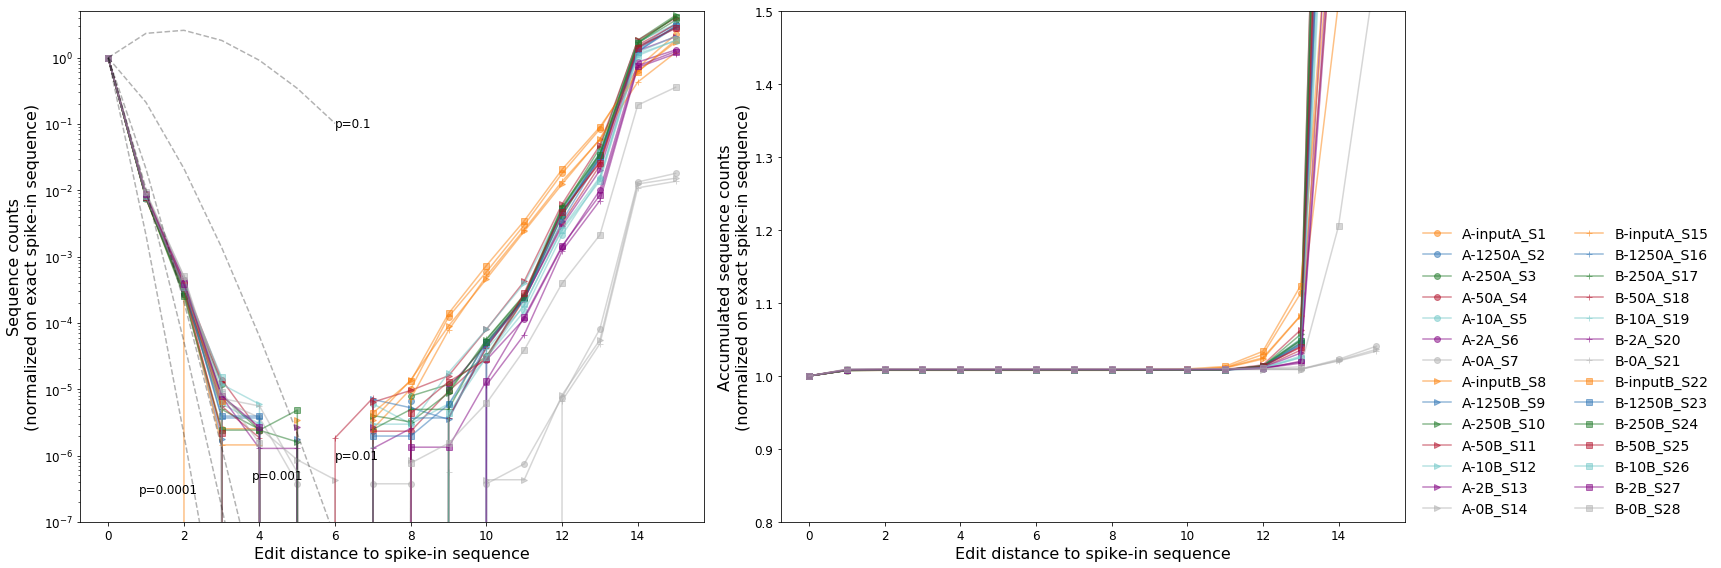

In [253]:
import util
print(util.color.BOLD + util.color.BLUE + 
      'Distribution of external standard peak'
      + util.color.END)
data.plot_std_peak_dist(sampleSet)

## Distribution of sample pools

Sequence length distribution in each sample


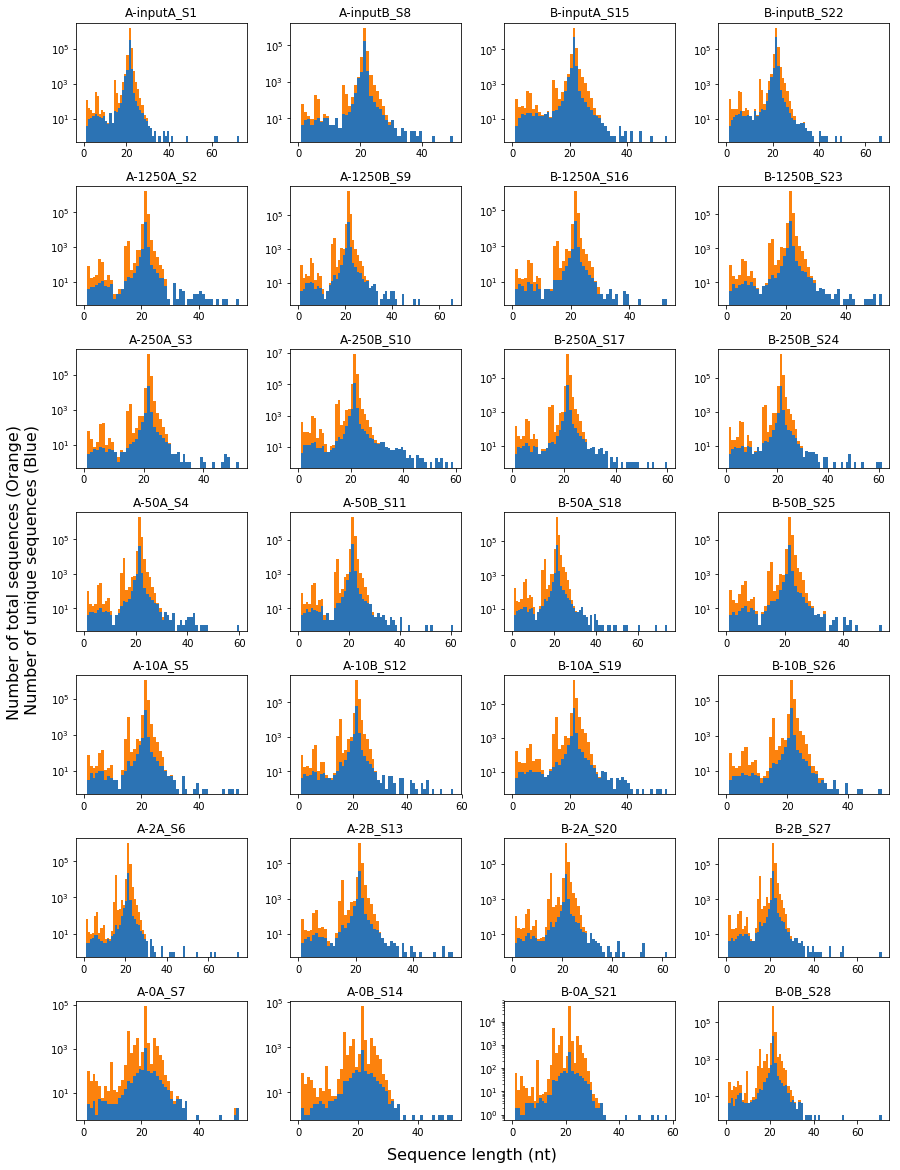

In [151]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample' + util.color.END)
data.print_length_dist(sampleSet, total=True, unique=True, blackList=stdSeqList)

Sequence composition distribution in each sample


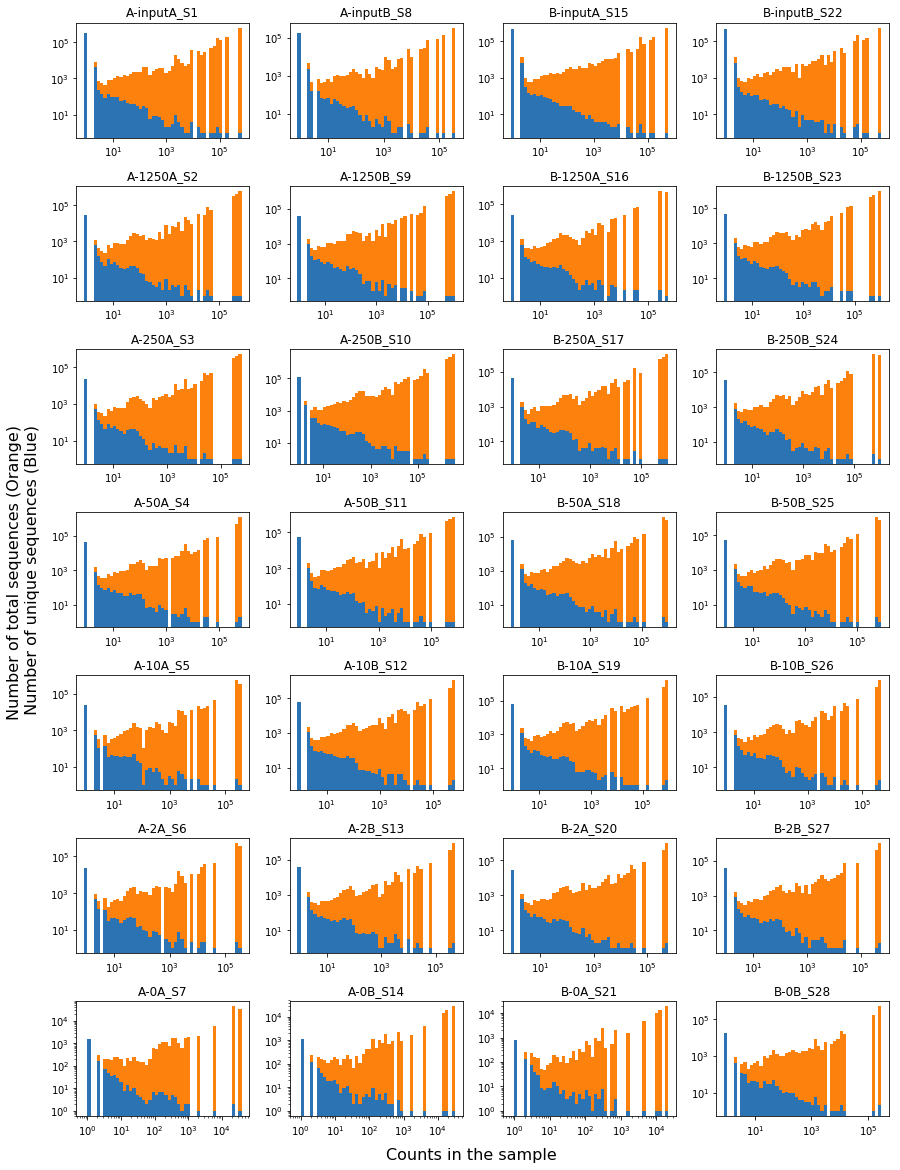

In [160]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence composition distribution in each sample' + util.color.END)

data.print_composition_dist(sampleSet, total=True, unique=True, blackList=stdSeqList)

### Sequencing error adjustment

In [3]:
from scipy.stats import poisson
n = 4e5
p = 0.001/3
for k in [1,2,3,4,5]:
    mu = n*(1-p)**(21-k)*p**k
    rv = poisson(mu)
    print('{}: mu={}, p(>1)={:,.5f}, p(>10)={:,.5f}'.format(k, mu, 1-rv.cdf(1), 1-rv.cdf(10)))

1: mu=132.44725363759653, p(>1)=1.00000, p(>10)=1.00000
2: mu=0.04416380581447033, p(>1)=0.00095, p(>10)=0.00000
3: mu=1.472617733060031e-05, p(>1)=0.00000, p(>10)=0.00000
4: mu=4.910362564388232e-09, p(>1)=0.00000, p(>10)=0.00000
5: mu=1.6373332992291534e-12, p(>1)=0.00000, p(>10)=0.00000


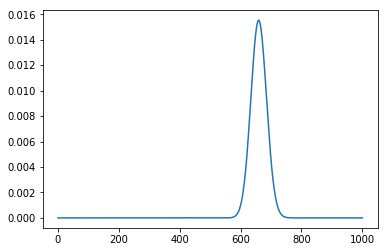

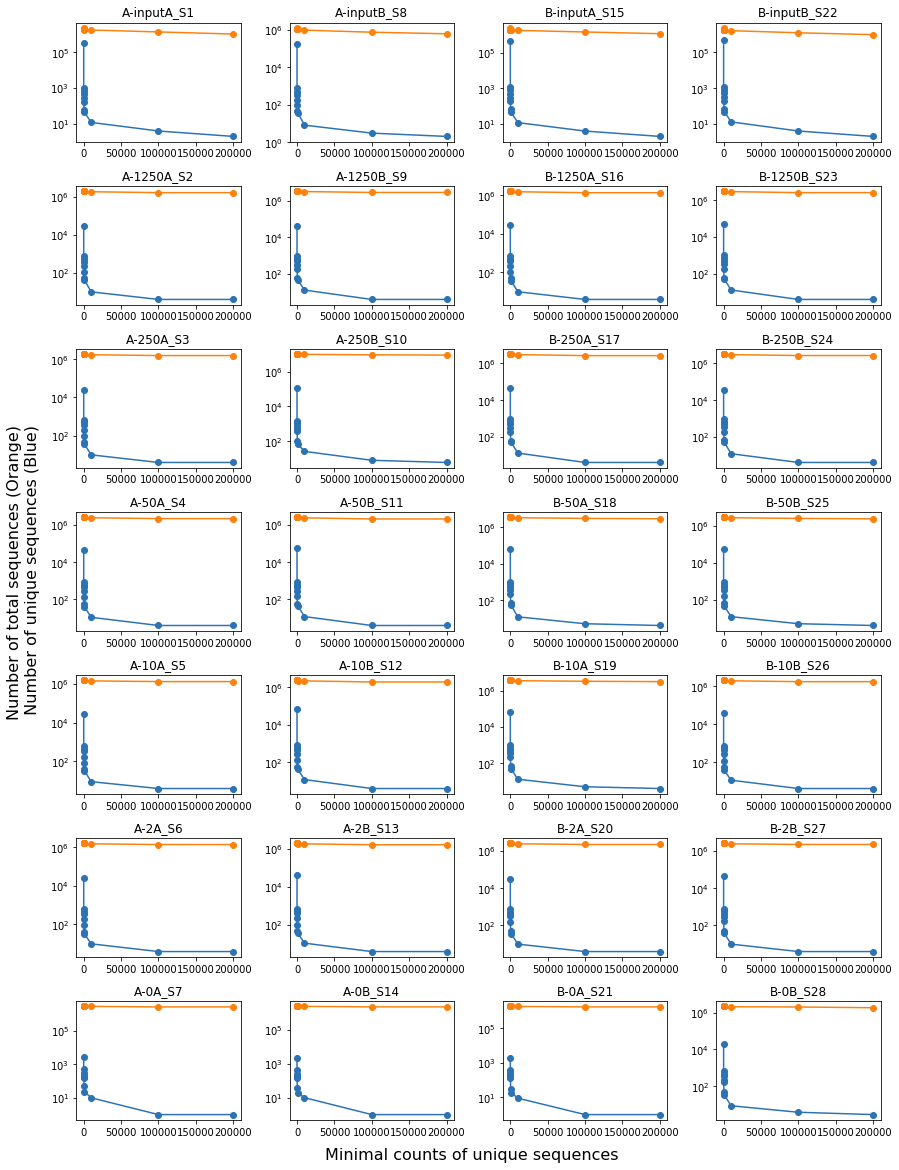

In [202]:
data.print_cutoff_changes(sampleSet=sampleSet)

Sequence length distribution in each sample (minimal sequence counts = 10)


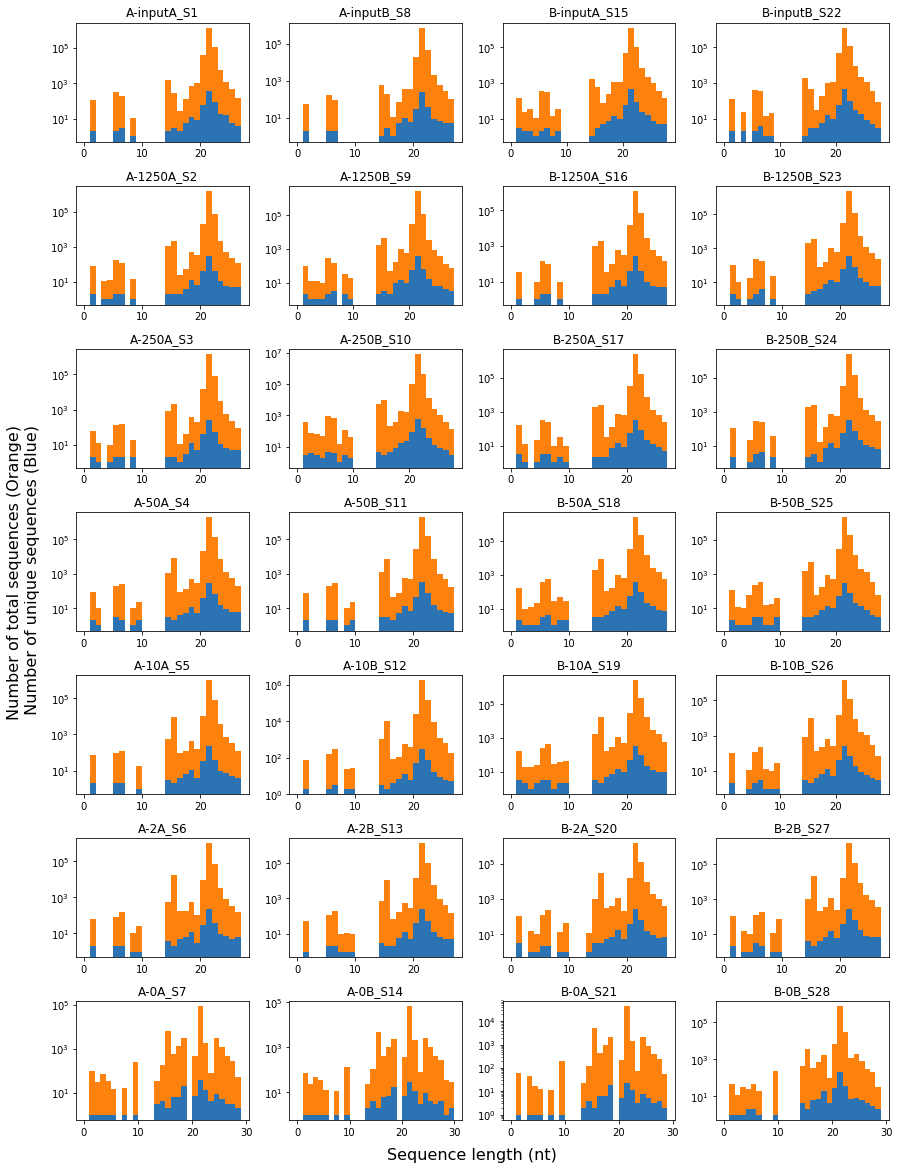

In [152]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample (minimal sequence counts = 10)' + util.color.END)
data.print_length_dist(sampleSet, total=True, unique=True, minCounts=10, blackList=stdSeqList)

Sequence composition distribution in each sample


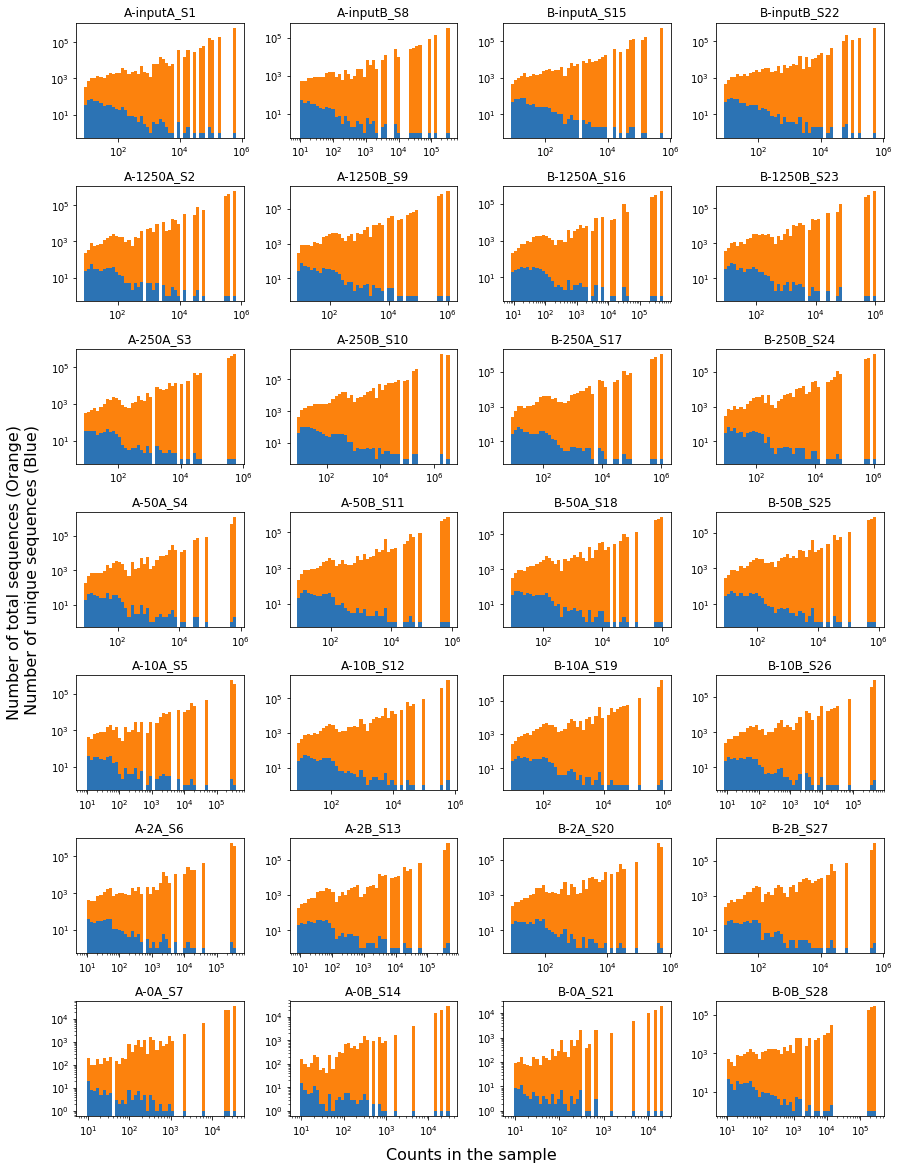

In [161]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence composition distribution in each sample' + util.color.END)

data.print_composition_dist(sampleSet, minCounts=10, total=True, unique=True, blackList=stdSeqList)

Use entropy efficiency to describe the distribution of sequences


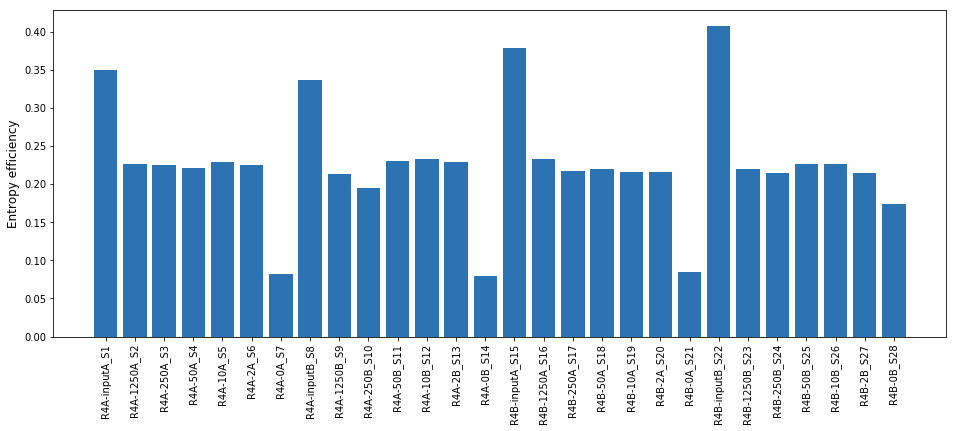

In [263]:
print(util.color.BOLD + util.color.BLUE + \
'Use entropy efficiency to describe the distribution of sequences' + util.color.END)


def bootstrap_fractions(fractions, size, depth=200):
    import numpy as np
    
    efficiencyList = []
    for _ in range(depth):
        sampleBootstrapped = np.random.choice([i for i in range(len(fractions))], p=fractions, replace=True, size=size)
        unique, counts = np.unique(sampleBootstrapped, return_counts=True)
        res = dict(zip(unique, counts))
        fractionsNew = [res[i]/size if i in res.keys() else 0 for i in range(len(fractions))]
        efficiencyList.append(-np.nansum(np.multiply(fractionsNew, np.log2(fractionsNew)))/np.log2(len(fractionsNew)))
    
    return efficiencyList

efficiencyList = bootstrap_fractions(sampleSet[0].get_seq_fraction(blackList='AAAAACAAAAACAAAAACAAA'), sampleSet[0].totalSeq)


fig = plt.figure(figsize=[16, 6])
ax = fig.add_subplot(111)

for ix in range(28):
    fractions = sampleSet[ix].get_seq_fraction()
    entropy_efficiency = -np.sum(np.multiply(fractions, np.log2(fractions)))/np.log2(len(fractions))
    plt.bar([ix], [entropy_efficiency], width=0.8, color='#2C73B4')

ax.set_xticks([i for i in range(28)])
ax.set_xticklabels([sample.id[:sample.id.find('_counts')] for sample in sampleSet], rotation=90)
ax.set_ylabel('Entropy efficiency', fontsize=12)
plt.show()

## Quantification factor

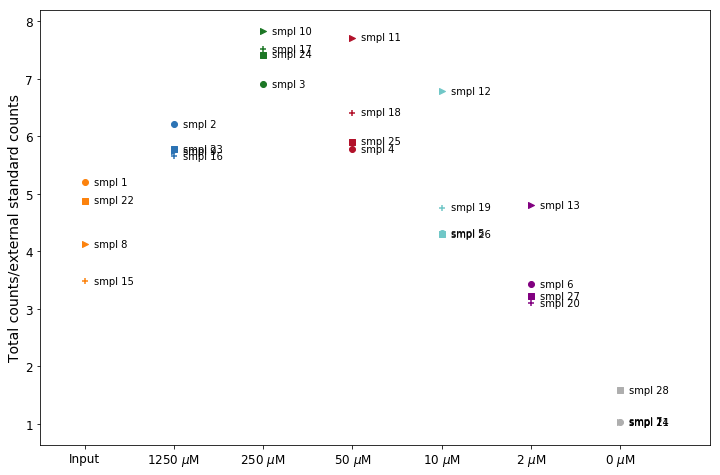

In [60]:
import matplotlib.pyplot as plt
import plot
rndToCal = [[i+1, i+8, i+15, i+22] for i in range(7)]

fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)
markerList = ['o', '>', '+', 's']
colorList = ['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE']
    
for ix, rndBatch in enumerate(rndToCal):
    for rndIx,rnd in enumerate(rndBatch):
        ax.scatter(ix, qFactorList[rnd-1][2]/qFactorList[rnd-1][1], marker=markerList[rndIx], color=colorList[ix])
        ax.text(s='smpl %i' %rnd, x=ix+0.1, y=qFactorList[rnd-1][2]/qFactorList[rnd-1][1], va='center', fontsize=10)
ax.set_xlim([-0.5, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Input', r'1250 $\mu$M', r'250 $\mu$M', r'50 $\mu$M', r'10 $\mu$M', r'2 $\mu$M', r'0 $\mu$M'], fontsize=12)
ax.set_ylabel('Total counts/external standard counts', fontsize=14)
plot.set_ticks_size(ax,fontSizeY=12)

plt.show()

# Valid sequences analysis
## Convert valid sequences to ```sequence_set```

In [545]:
sequence_set = pre_processing.SequenceSet(sample_set=sample_set, remove_spike_in=True, note='test')

In [550]:
zero_samples = [sample_name for sample_name in sequence_set.sample_info.keys() if '-0' in sample_name]
sequence_set.get_reacted_frac(
    input_average='median',
    black_list=zero_samples,
    inplace=True
)

## Valid sequence characterization

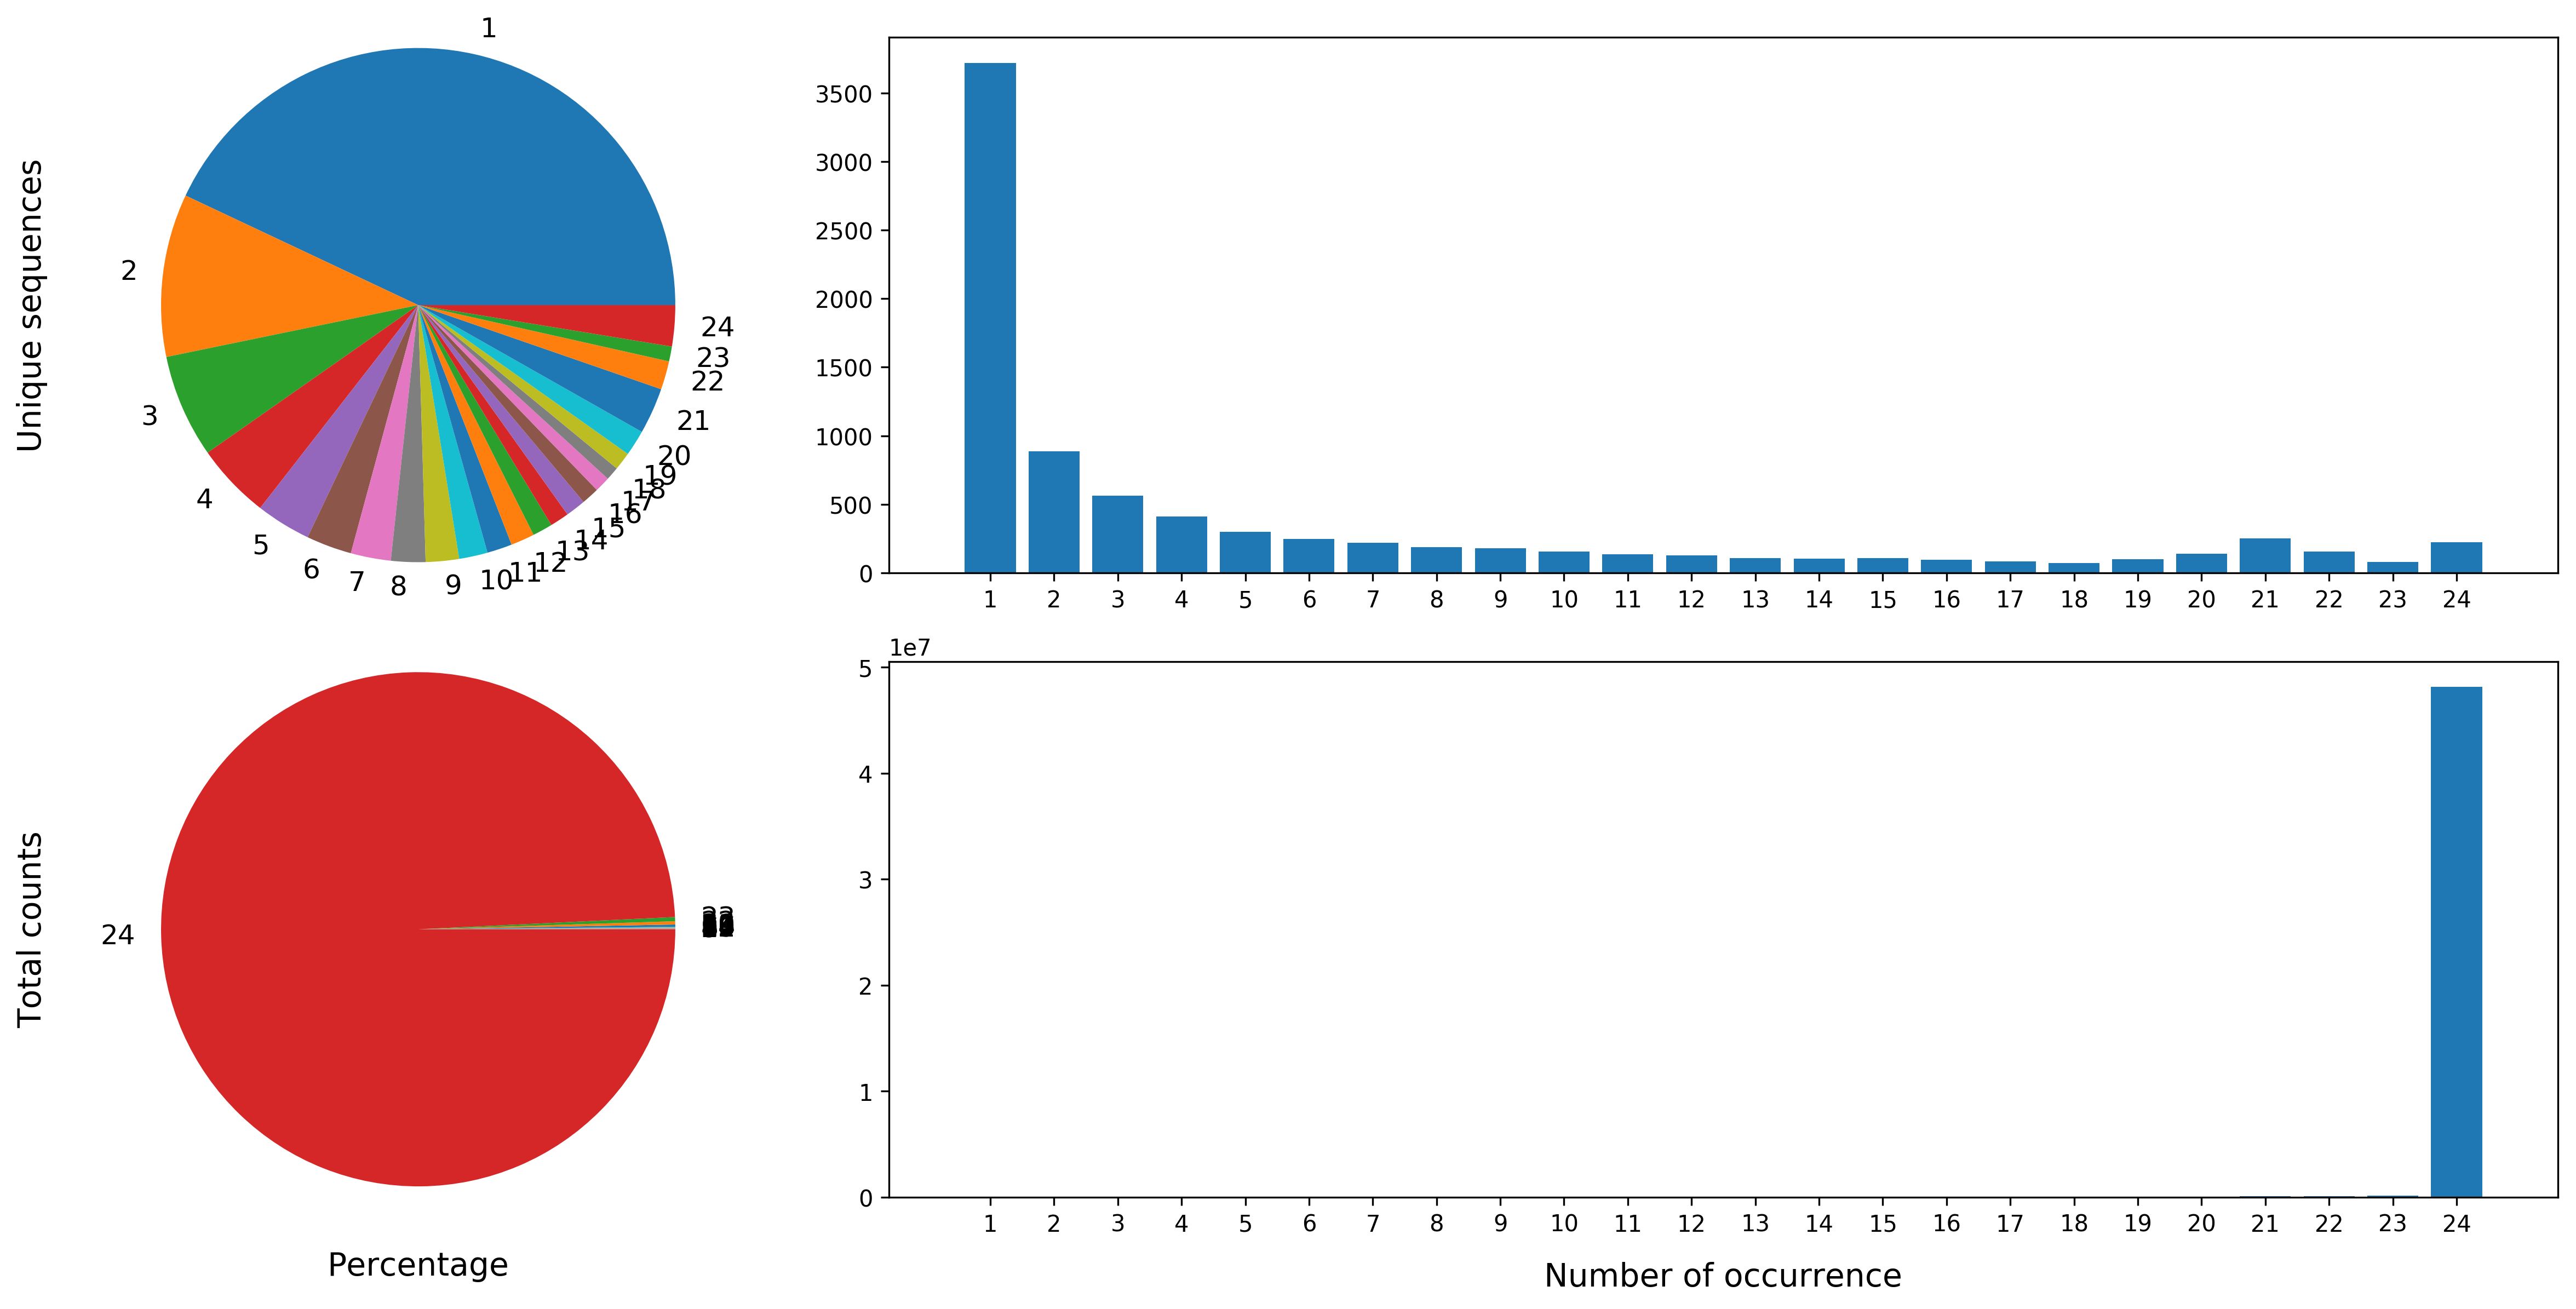

In [567]:
count_bins, count_bins_weighted = analysis.survey_seq_occurrence(sequence_set=sequence_set, display=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


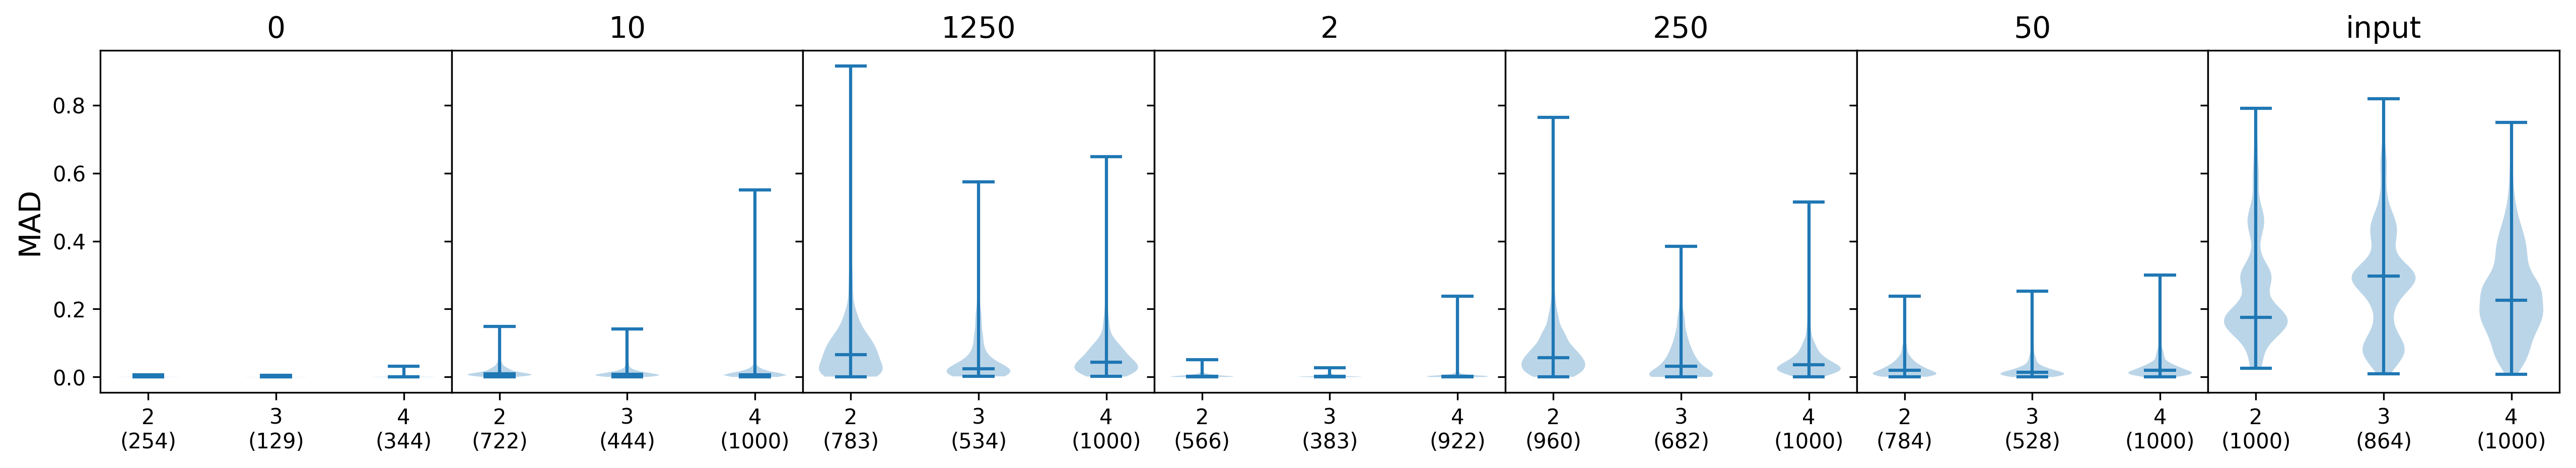

In [569]:

_ = analysis.analyze_rep_variability(sequence_set, display=True, key_domain='byo',percentage=False)

# Fitting

In [425]:
import multiprocessing as mp

flag='this is flag'

def work_fn(col):
    print('seq:{}\tsum:{}; flag:{}'.format(col[0], np.nansum(list(col[1])), flag))

pool = mp.Pool(processes=4)
results = pool.map(work_fn, sequence_set.reacted_frac_table.iloc[:10].iterrows())

seq:ATTCACCTAGGTCATCGGCTGT	sum:2.9524773679864404; flag:this is flag
seq:CTACTTTAAACAATCGGTCTC	sum:1.1651032743869087; flag:this is flag
seq:CCGCTTCATACAATCGGTTTG	sum:4.568002181606462; flag:this is flag
seq:TTACCTTGGTCATCGAGTGT	sum:2.0456324234721492; flag:this is flag
seq:CCGCTTCAAGCAATCGGACGC	sum:0.20711076834767175; flag:this is flag
seq:TTACCCTGGACATCGAGTGT	sum:1.7824983396030338; flag:this is flag
seq:TTCAAACAATCGGTCGCGGTT	sum:0.0831211369106148; flag:this is flag
seq:AGTGGAGACCTGCCCGTGTGA	sum:0.2682265534683705; flag:this is flag
seq:ATTAGCCTGGTCATCGAGTGT	sum:5.939569148437322; flag:this is flag
seq:TCTCAATTGTATGCACCGTGT	sum:0.09841479036310784; flag:this is flag


In [498]:
sequence_set_test = sequence_set
print(sequence_set_test.reacted_frac_table.__dict__.keys())
sequence_set_test.reacted_frac_table.drop(labels=sequence_set_test.reacted_frac_table.index[11:], inplace=True)
sequence_set_test.reacted_frac_table.__dict__.keys()

dict_keys(['is_copy', '_data', '_item_cache', 'input_avg_type', 'col_x_values', 'input_avg', '_iloc'])


dict_keys(['is_copy', '_data', '_item_cache', 'input_avg_type', 'col_x_values', 'input_avg', '_iloc'])

In [541]:
fitting.fitting_sequence_set(sequence_set=sequence_set_test, inplace=True, parallel_threads=6)

/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq

In [535]:
def func_1(arg_1, arg_2, arg_3, **kwargs):
    print(arg_1)
    print(arg_2)
    print(arg_3)
    print('kwargs:{}'.format(kwargs))

def func_2(arg_1, **kwargs):
    func_1(arg_1=arg_1, **kwargs)
    
func_2(arg_1=1, arg_2=2, arg_3=3, arg_4=34)

1
2
3
kwargs:{'arg_4': 34}


# Fitting results analysis

In [275]:
fittingRes = util.load_pickle(dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes_bfo_deep.pkl')

fittingRes_bfo_deep.pkl:
Fitting results of BFO data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores)


In [638]:
sample_set[0].__dict__

{'file_dirc': '/mnt/storage/projects/k-seq/input/bfo_counts/counts/R4A-inputA_S1_counts.txt',
 'metadata': {'byo': 'input',
  'sample_id': 1,
  'select_rep': 'A',
  'sequence_rep': 'A'},
 'name': 'R4A-inputA_S1',
 'quant_factor': 4092157.4107959745,
 'quant_factor_max_dist': 2,
 'sample_type': 'input',
 'sequences': {'CTACTTCAAACAATCGGTCTG': 605843,
  'AAAAACAAAAACAAAAACAAA': 395313,
  'ATTACCCTGGTCATCGAGTGA': 187328,
  'ATTACCCTGGTCATCGAGTGT': 122377,
  'ATTCACCTAGGTCATCGGGTG': 88556,
  'CTCTTCAAACAATCGGTCTTC': 84124,
  'ATTCACCTAGGTCATCGGGTGT': 63570,
  'CCACACTTCAAGCAATCGGTC': 46155,
  'CCGCTTCAAACAATCGGTTTG': 28860,
  'ATTCACCTAGGTCATCGAGTGT': 19347,
  'ACCCACTTCAAACAATCGGTC': 17460,
  'CACACTTCAAGCAATCGGTC': 15162,
  'CTGCTTCAAACAATCGGTGTG': 9758,
  'TACTTCAAACAATCGGTCTG': 9361,
  'ATTCACCTAGGTCATCGAGTGA': 8729,
  'CTACTTCAAACAATCGGTCTTC': 8534,
  'CTGTTTCAAACAATCGGTCTC': 6329,
  'CCACTTCAAACAATCGGTCTG': 4875,
  'ATTCACCTAGGTCATCGGGTGTT': 3694,
  'CCAGTCTTCAAACAATCGGTC': 3497,
  '

limit_output extension: Maximum message size of 10000 exceeded with 31209 characters

In [615]:
import pickle

encoded = pickle.dumps(ob)
ob_recovered = pickle.loads(encoded)

'<__main__.SampleClass object at 0x7facc7122c18>'

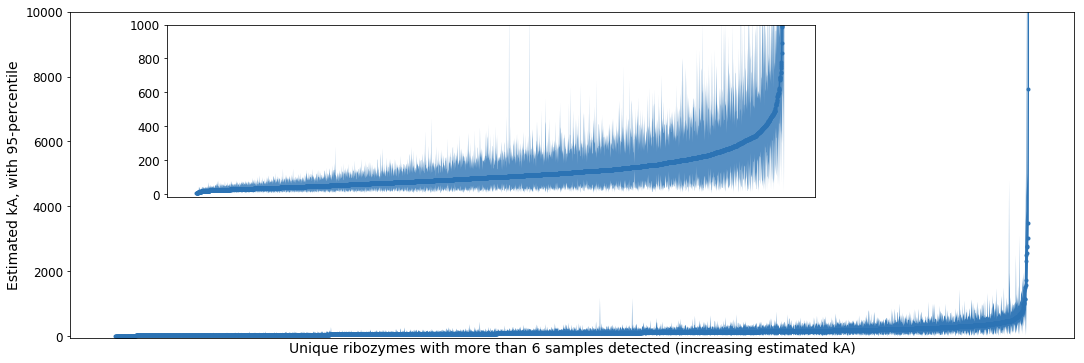

In [183]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 10000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 1000])
    axInset.set_xticks([])
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
# Only survey ribozymes at least detected 6 times and the CI can be estimated, return prediction and CI
for res in fittingRes:
    if np.sum(~np.isnan(res['kSeqFmol'])) >= 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [185]:
len(surveyRes)

3039

In [175]:
def get_config(res):
    return np.sum(~np.isnan(res['kSeqFmol'].reshape(4, 5)), axis=0)

def sort_fn(res):
    if np.isnan(res['params'][2]):
        return (0, 0)
    elif len(res['ci95'])==1:
        return (1, 0)
    else:
        return (1, res['ci95'][2][1])


def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%i,%s,' %(res['seq'], np.nanmedian(res['initRaw']), get_config(res)))
            if np.isnan(res['params'][2]):
                output.write('0,0,%s\n' %(','.join(['nan' for i in range(15)])))
            elif len(res['ci95'])==1:
                output.write('1,0,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2], ','.join(['nan' for i in range(12)])))
            else:
                output.write('1,1,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][0]) + list(res['ci95'][1])])))

export_csv(fittingRes, dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [15]:
import pandas as pd

df = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [18]:
df.sort_values(by='inputCountMedian', ascending=False)

,seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
1949,CTACTTCAAACAATCGGTCTG,535826,[4 4 4 4 4],1,1,0.498193,185.846359,92.587327,64.435804,110.333514,172.973943,112.032047,NaN,0.582553,0.833534,0.600586,83.919158,192.976127,322.371536,192.997970
2248,AAAAACAAAAACAAAAACAAA,424144,[4 4 4 4 4],1,1,0.291822,134.625474,39.286699,29.450650,97.248256,221.326316,105.025213,0.368629,0.733697,1.000000,0.739579,32.178357,137.516680,423.558510,161.594631
282,ATTACCCTGGTCATCGAGTGA,166719,[4 4 4 4 4],1,1,0.897218,249.531760,223.884271,215.025539,352.185247,596.050062,367.764027,0.903414,1.000000,1.000000,0.993663,216.560758,355.083154,602.780817,370.170092
197,ATTACCCTGGTCATCGAGTGT,119288,[4 4 4 4 4],1,1,1.000000,284.907161,284.907161,293.761225,413.852201,676.772235,432.719099,1.000000,1.000000,1.000000,0.999463,293.761225,414.863798,676.772235,432.957706
4470,CTCTTCAAACAATCGGTCTTC,73892,[4 4 4 4 4],1,1,0.236052,116.392017,27.474539,19.776042,33.141220,59.958931,35.208687,0.216635,0.271530,0.458105,0.292468,47.977486,122.463424,227.548844,127.382156
3859,ATTCACCTAGGTCATCGGGTG,63062,[4 4 4 4 4],1,1,0.304344,116.469068,35.446720,26.988388,49.081517,97.616269,53.639380,0.294006,0.404862,0.767824,0.438493,37.610860,124.573785,257.007807,133.259215
1025,ATTCACCTAGGTCATCGGGTGT,62453,[4 4 4 4 4],1,1,0.298714,559.444397,167.113692,134.185163,176.329546,284.608795,186.155354,0.284175,0.328169,0.397175,0.330130,360.990341,546.440081,923.819656,571.004964
4493,CCACACTTCAAGCAATCGGTC,50627,[4 4 4 4 4],1,1,0.140133,195.437983,27.387217,16.717935,32.597901,55.281122,33.206819,0.128337,0.162480,0.259436,0.171929,69.150021,210.763949,363.453127,204.490103
1738,CCGCTTCAAACAATCGGTTTG,33567,[4 4 4 4 4],1,1,0.471540,220.232388,103.848293,69.467598,120.279570,180.443176,120.908248,0.447817,0.545243,0.739890,0.556521,104.960830,224.587700,352.346250,223.069532
1028,ATTCACCTAGGTCATCGAGTGT,18526,[4 4 4 4 4],1,1,0.416950,381.886042,159.227321,103.883256,175.772415,278.100993,182.805232,0.404696,0.471860,0.610054,0.481229,172.178304,378.198487,612.157516,386.911850


limit_output extension: Maximum message size of 10000 exceeded with 33203 characters

In [19]:
len(df)

9086

In [34]:
def filter_fn(seq):
    return np.sum([int(seq[1]['config'][i]) for i in [1,3,5,7]])>=6

dfNew = df[[filter_fn(seq) for seq in df.iterrows()]]

In [38]:
dfNew.sort_values(by='kA', ascending=False)

,seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,ASD,...,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
39,TGATTTCAAGCAATCGGTCTG,1,[3 1 2 0],1,1,47393.092714,0.023731,1124.681409,18558.252350,0.005864,...,1361.143523,521.758719,336.607840,22355.410823,44230.315533,21636.397353,0.014261,0.025108,0.037842,0.025552
0,CCAAAACTTCAAACAATCGGTC,6,[6 5 3 4],1,1,715.681578,1.000000,715.681578,14192.261172,0.128773,...,9981.876047,3705.642877,281.647950,2350.794557,11038.902086,4638.638897,0.485171,1.000000,1.000000,0.963271
1,CCGCTTCAAATCGGTTTG,1,[4 3 1 4],1,1,588.307672,1.000000,588.307672,14476.015536,0.142513,...,6712.771984,2739.551729,309.639914,2205.351800,7419.087659,3769.991121,0.342088,1.000000,1.000000,0.964377
513,ACTTCAAACAATCGATCGGCA,1,[1 3 2 0],1,1,37924.521060,0.011610,440.293696,18449.329375,0.002689,...,638.036378,254.122432,335.333375,13614.048748,44350.154713,21437.002189,0.008136,0.012399,0.018362,0.012786
3,CTACTTCAAATCGGTCTG,2,[5 4 0 4],1,1,408.258222,1.000000,408.258222,15852.336184,0.210323,...,2712.748157,1418.313756,168.848633,1581.160551,3511.853783,2809.306485,0.217108,1.000000,1.000000,0.916502
30,CCAAGTTTTCAAACAATCGGTC,1,[6 5 3 4],1,1,356.832986,1.000000,356.832986,590.956533,0.191603,...,1350.925294,569.515200,167.315436,502.858706,1987.092234,716.938083,0.398787,1.000000,1.000000,0.883993
27,CCGCACTTCAAGCAATCGGTCT,1,[6 5 3 4],1,1,354.696222,1.000000,354.696222,342.534403,0.136793,...,1132.152394,551.457801,218.996384,513.916775,1462.212706,623.362779,0.553848,1.000000,1.000000,0.923439
23,CCGCTTCACAATCGGTTTG,1,[6 4 3 4],1,1,339.557477,1.000000,339.557477,6820.497223,0.246945,...,3207.372280,1005.406558,91.331007,606.428400,6269.464857,1570.800522,0.197823,1.000000,1.000000,0.858887
99,GCTTCAACCAATCGGTCCGCC,1,[6 5 3 4],1,1,273.434894,1.000000,273.434894,167.654734,0.136158,...,541.186190,317.409512,182.031658,330.960269,887.178090,369.019676,0.551678,1.000000,1.000000,0.902670
58,CCGCTTCAAACAATCCGTTTG,3,[6 5 3 4],1,1,255.810825,1.000000,255.810825,111.381041,0.099733,...,492.922997,337.307955,211.121819,345.340360,643.187739,362.684423,0.649195,1.000000,1.000000,0.948428


limit_output extension: Maximum message size of 10000 exceeded with 31468 characters

In [246]:
selected_seq['S-1A.1-a']

{'gel_shift_data': array([[0.43969945, 0.26818966, 0.12608435, 0.0882598 , 0.07635634],
        [0.42030006, 0.23722362, 0.07205889, 0.03691233, 0.03135119],
        [0.41725538, 0.25986244, 0.08677028, 0.04042544, 0.0331289 ]]),
 'gel_shift_res': {'bs_params': array([[  0.61085818, 161.60857694,  98.71992148],
         [  1.        , 154.59564204, 154.59564204],
         [  0.74603574, 507.93705365, 378.93919372],
         ...,
         [  1.        , 345.91275997, 345.91275997],
         [  1.        , 263.21215029, 263.21215029],
         [  1.        , 125.47543986, 125.47543986]]),
  'mean': array([  0.89205005, 452.38857865, 376.86906718]),
  'params': array([  0.42538185, 131.41261085,  55.90053901]),
  'pcov': array([[ 4.94246009e-04, -2.75404256e-01],
         [-2.75404256e-01,  4.06292765e+02]]),
  'pct_res': array([ 4.07865454e-02, -7.10486272e-04,  6.39995140e-01,  4.30853146e+00,
          2.16010295e+01, -5.13261896e-03, -1.16091630e-01, -6.27208253e-02,
          1.22015

# Compare to gel shift data
## import data

In [367]:
selected_seq = [
    ('S-2.1-a', 'ATTACCCTGGTCATCGAGTGA'),
    ('S-2.1-t', 'ATTACCCTGGTCATCGAGTGT'),
    ('S-1A.1-a', 'CTACTTCAAACAATCGGTCTG'),
    ('S-1B.1-a', 'CCACACTTCAAGCAATCGGTC'),
    ('S-1B.2-a', 'CCGCTTCAAGCAATCGGTCGC'),
    ('S-1B.3-a', 'CCGAGTTTCAAGCAATCGGTC'),
    ('S-3.1-a', 'AAGTTTGCTAATAGTCGCAAG'),
]

#####---------------- load k-seq data ----------------------------
k_seq_results = util.load_pickle('/mnt/storage/projects/k-seq/working/bfo_evan/fittingRes_bfo_deep_new_alpha.pkl')
k_seq_results = {seq['seq']: seq for seq in k_seq_results}

######--------------- below is appended new dataset -----------------

gel_reacted_frac = {
    'S-2.1-a': [[0.489295509, 0.419323485, 0.305418426, 0.120166882, 0.035873405, 0.016173072],
                [0.478626156, 0.403143794, 0.274715664, 0.102872995, 0.033116803, 0.017166082],
                [0.489551715, 0.426821441, 0.301406226, 0.117392596, 0.034023201, 0.015117505]], #same as previous
    'S-2.1-t': [[0.247654488, 0.170506483, 0.100291314, 0.049161798, 0.027529764, 0.018740413],
                [0.229005216, 0.151884012, 0.089851748, 0.033955861, 0.012286652, 0.017338768],
                [0.231373165, 0.149670088, 0.084938506, 0.033389647, 0.015474962, 0.01170447],
                [0.243403682, 0.153396259, 0.095408276, 0.042586067, 0.019300099, 0.012896074],
                [0.226927481, 0.140380394, 0.091431174, 0.042169283, 0.018667761, 0.010952174],
                [0.230181996, 0.146927058, 0.096956494, 0.047895733, 0.018487228, 0.009239871]], # last three rows are newly added
    'S-1A.1-a': [[0.439699452, 0.268189655, 0.126084347, 0.088259795, 0.076356344, 0.059860081],
                 [0.420300055, 0.237223625, 0.072058892, 0.036912327, 0.031351187, 0.029645931],
                 [0.417255385, 0.259862445, 0.086770284, 0.040425438, 0.033128899, 0.031331471]], # large change from last data
    'S-1B.1-a': [[0.416238141, 0.184055558, 0.068116894, 0.028315413, 0.004227116, 0.004596165],
                 [0.455159602, 0.218512114, 0.065886528, 0.025261185, 0.014807864, 0.013362008],
                 [0.330508197, 0.121268749, 0.039476592, 0.02612634, 0.022842214, 0.020548252]], # last one row is newly added, and seems smaller than previous two
    'S-1B.2-a': [[0.391371256, 0.15789507, 0.051620219, 0.032881246, 0.030953661, 0.028037674],
                 [0.432537944, 0.185661549, 0.052941428, 0.021257904, 0.017119468, 0.019511053],
                 [0.288784317, 0.102286783, 0.038452036, 0.02845557, 0.026151375, 0.02505473]], # last one row is newly added, and seems smaller than previous two
    'S-1B.3-a': [[0.372488705, 0.181137492, 0.063979744, 0.034339158, 0.027761498, 0.024546059],
                 [0.414744167, 0.211518582, 0.078759508, 0.030439581, 0.019163878, 0.01264281],
                 [0.308792227, 0.120899245, 0.045028565, 0.031398849, 0.027748936, 0.026723334],
                 [0.47562996, 0.268289712, 0.08550071, 0.036814349, 0.026340063, 0.022892661],
                 [0.462661054, 0.265942326, 0.092524106, 0.044660471, 0.03144388, 0.028969754]], # new dataset
    'S-3.1-a':  [[0.629629071, 0.267061308, 0.084716043, 0.041885866, 0.033853309, 0.031580398],
                 [0.693690731, 0.355765177, 0.112267161, 0.046034788, 0.031727659, 0.028746741],
                 [0.688746745, 0.365462046, 0.118545135, 0.048411197, 0.035810519, 0.033815235]] # newly added data
}
 
#mask 0 BFO concentration
for seq in gel_reacted_frac.keys():
    gel_reacted_frac[seq] = np.array(gel_reacted_frac[seq])[:, :-1]
    

# ------------------------    
selected_seq = {
    seq[0]:{
        'seq': seq[1],
        'k_seq_data': k_seq_results[seq[1]]['reactedFrac'].reshape(4, 5),
        'gel_shift_data': gel_reacted_frac[seq[0]]
    } for seq in selected_seq
}

fittingRes_bfo_deep_new_alpha.pkl:
Fitting results of BFO data with new degradation coefficient alpha, including the CI 95 estimation using 1000 bootstrap, on Pod (15 cores)


## fitting

In [378]:
def func(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))


def fitting_classic(x, y_list):
    result = {}
    result['point_estimation'] = fitting.fitting_single(x_data=np.array(x), 
                                                        y_data=np.mean(y_list, axis=0),
                                                        bounds=([0, 0], [1., np.inf]),
                                                        ci_est=False,
                                                        func=func,
                                                        missing_data_as_zero=False)['params']
    result['point_estimation'] = [result['point_estimation'][0],
                                  result['point_estimation'][1],
                                  result['point_estimation'][0]*result['point_estimation'][1]]
    result['rep_res'] = np.array([
        fitting.fitting_single(x_data=np.array(x),                    
                               y_data=y_list[i],           
                               bounds=([0, 0], [1., np.inf]),          
                               ci_est=False,
                               func=func,
                               missing_data_as_zero=False)['params']
        for i in range(3)
    ])
    params = result['rep_res']
    result['rep_res'] = np.append(params.T, [params[:, 0]*params[:, 1]], axis=0).T
    result['sd_estimation'] = np.std(result['rep_res'], axis=0, ddof=1)
    return result


def fitting_bs(x, y_list):
    
    x_data = np.tile(x, len(y_list))
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = np.reshape(a=y_list, newshape=np.size(y_list))
    result = fitting.fitting_single(x_data=x_data,             
                                     y_data=y_data,                    
                                     bounds=([0, 0], [1., np.inf]),                    
                                     bs_depth=1000,    
                                     bs_return_all=True,                    
                                     ci_est=True,               
                                     func=func,                      
                                     missing_data_as_zero=False)
    result['params'] = np.append(result['params'], result['params'][0]  *result['params'][1])
    params = np.array(result['bs_params'])
    result['bs_params'] = np.append(params.T, [params[:, 0]*params[:, 1]], axis=0).T
    result['mean'] = np.nanmean(result['bs_params'], axis=0)
    result['sd'] = np.nanstd(result['bs_params'], axis=0, ddof=1)
    result['percentiles'] = {
                '2.5': np.percentile(result['bs_params'], 2.5, axis=0),
                '50': np.percentile(result['bs_params'], 50, axis=0),
                '97.5': np.percentile(result['bs_params'], 97.5, axis=0)
            }
    return result

x_series = list(np.array([1250, 250, 50, 10, 2])*1e-6)

# fitting for gel_shift_data
for seq in selected_seq.keys():
    # calculate classic method for both dataset
    selected_seq[seq]['k_seq_res_classic'] = fitting_classic(x_series, selected_seq[seq]['k_seq_data'])
    selected_seq[seq]['gel_shift_res_classic'] = fitting_classic(x_series, selected_seq[seq]['gel_shift_data'])
    # calculate bootstrap method for both dataset
    selected_seq[seq]['k_seq_res_bs'] = fitting_bs(x_series, selected_seq[seq]['k_seq_data'])
    selected_seq[seq]['gel_shift_res_bs'] = fitting_bs(x_series, selected_seq[seq]['gel_shift_data'])

## Results analysis
### On classic methods

In [379]:
def plot_param_alignment(selected_seq, method='bs', param='k', log=True):

    import plot
    import matplotlib.pyplot as plt
    import numpy as np
    
    param_sym = param
    param_map = {'A':0, 'k':1, 'kA':2}
    param = param_map[param]
    
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111)
    
    k_seq_res_key ='k_seq_res_{}'.format(method)
    gel_shift_res_key = 'gel_shift_res_bs'.format(method)
    if method == 'bs':
        k_seq_points = [selected_seq[seq]['k_seq_res_bs']['percentiles']['50'][param] for seq in selected_seq.keys()]
        k_seq_ci = [(selected_seq[seq]['k_seq_res_bs']['percentiles']['50'][param] - selected_seq[seq][k_seq_res_key]['percentiles']['2.5'][param],
                     selected_seq[seq]['k_seq_res_bs']['percentiles']['97.5'][param] - selected_seq[seq][k_seq_res_key]['percentiles']['50'][param])
                    for seq in selected_seq.keys()]
        gel_shift_points = [selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param] for seq in selected_seq.keys()]
        gel_shift_ci = [(selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param] - selected_seq[seq]['gel_shift_res_bs']['percentiles']['2.5'][param],
                 selected_seq[seq]['gel_shift_res_bs']['percentiles']['97.5'][param] - selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param])
                        for seq in selected_seq.keys()]
    else:
        k_seq_points = [selected_seq[seq]['k_seq_res_classic']['point_estimation'][param]
                        for seq in selected_seq.keys()]
        k_seq_ci = [selected_seq[seq]['k_seq_res_classic']['sd_estimation'][param]*2/np.sqrt(3)
                    for seq in selected_seq.keys()]
        gel_shift_points = [selected_seq[seq]['gel_shift_res_classic']['point_estimation'][param]
                        for seq in selected_seq.keys()]
        gel_shift_ci = [selected_seq[seq]['gel_shift_res_classic']['sd_estimation'][param]*2/np.sqrt(3)
                    for seq in selected_seq.keys()]
    
    ax.errorbar(x=k_seq_points, y=gel_shift_points,
                xerr=np.array(k_seq_ci).T, yerr=np.array(gel_shift_ci).T,
                marker='o', linestyle='', capsize=5, alpha=0.5)
    # plot.set_ticks_size(ax)

    ax.plot([0, 2000], [0, 2000], 'k--', alpha=0.5)
    ax.set_ylim([1, 2000])
    ax.set_xlim([1, 2000])
    if log:
        ax.set_yscale('log')
        ax.set_xscale('log')
    
    ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(param_sym), fontsize=14)
    ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(param_sym), fontsize=14)
    plt.show()

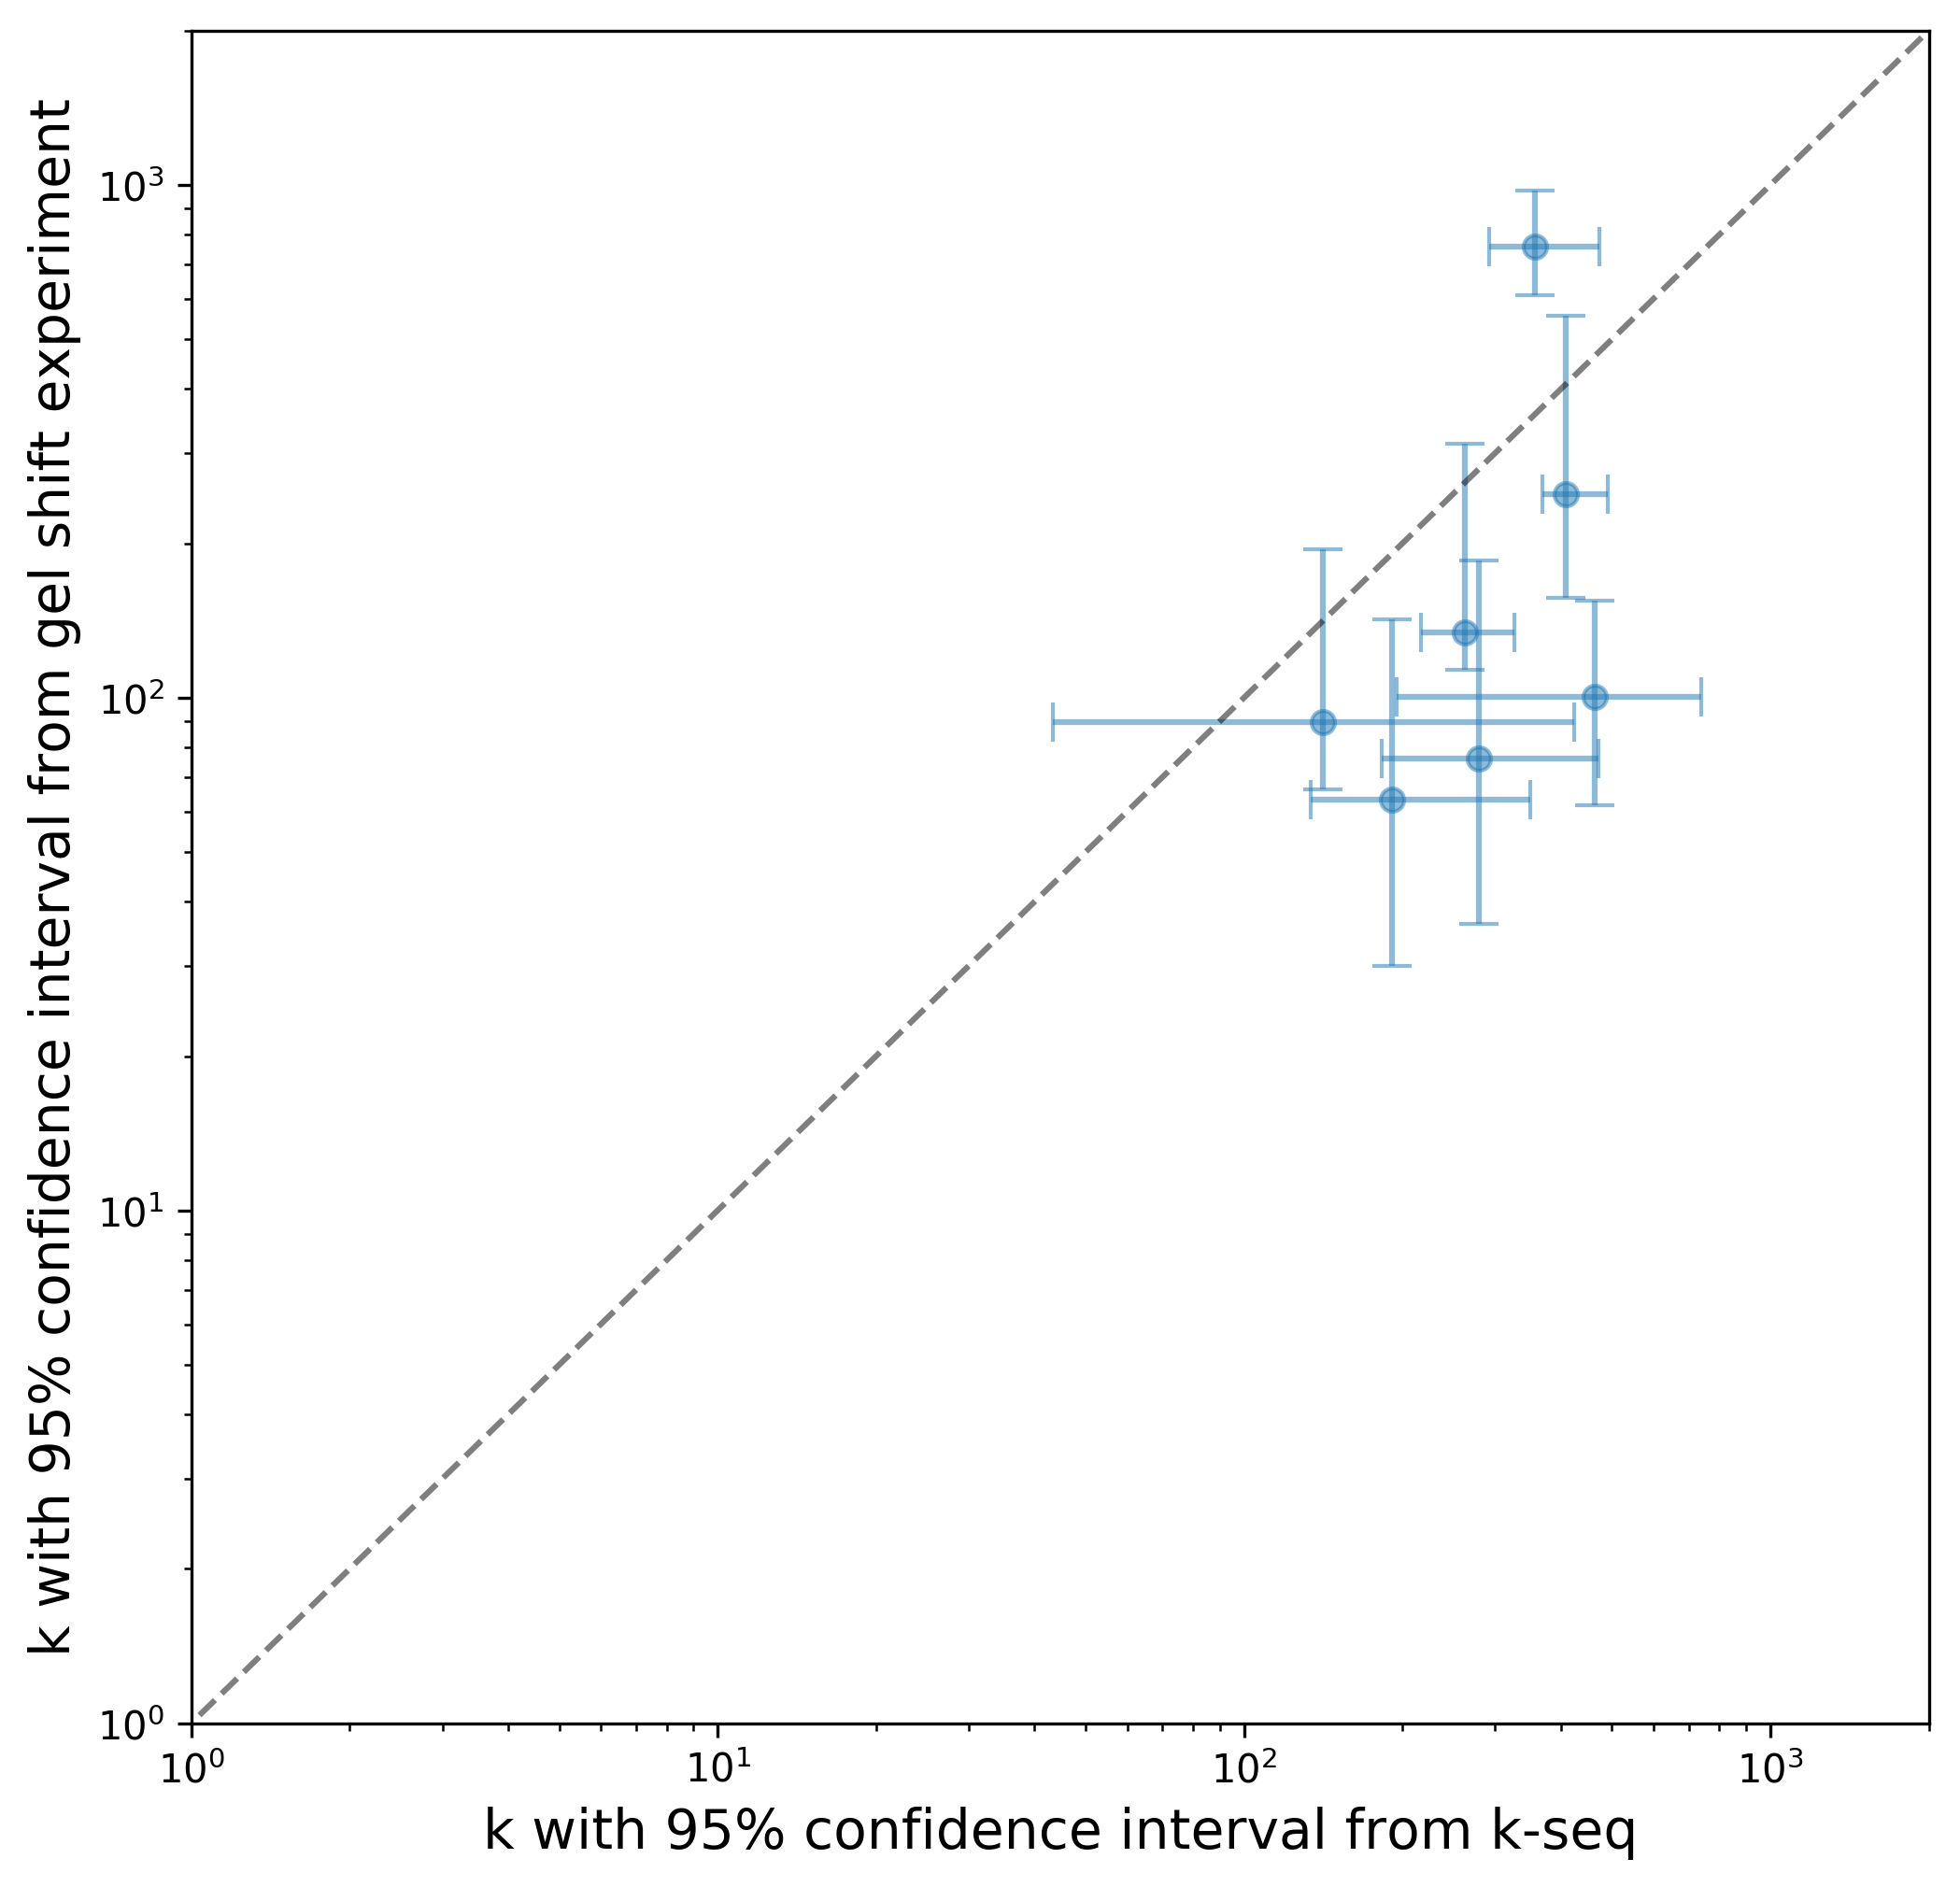

In [381]:
plot_param_alignment(selected_seq, method='bs', param='k', log=True)

In [383]:
for seq in selected_seq.keys():
    print('{}+-{}'.format(selected_seq[seq]['k_seq_res_classic']['point_estimation'][1], selected_seq[seq]['k_seq_res_classic']['sd_estimation'][1]*2/np.sqrt(3)))

354.55850373108507+-98.04184995221482
404.83624831597626+-79.32525233815313
264.0773386875383+-123.61166291691302
277.7028796493548+-344.5129581150551
186.9272771892548+-273.26001667795134
458.768496880749+-757.2387501389352
139.74489409125744+-184.6618699865587


In [382]:
import pprint

for seq in selected_seq.keys():
    print("------------------------------{}-------------------------------".format(seq))
    print(np.std(gel_reacted_frac[seq], axis=0, ddof=1)/np.mean(gel_reacted_frac[seq], axis=0))
    for ix, i in enumerate(selected_seq[seq]['gel_shift_res']['pct_res']):
        if ix%5 == 4:
            print(i)
        else:
            print("{}  ".format(i), end="")
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    plt.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    plt.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params']), color='#FC820D', ls='--', alpha=0.5)
    plt.xlim([-0.0001, 0.002])
    plt.show()

------------------------------S-2.1-a-------------------------------
[0.01283433 0.02905939 0.05679503 0.08184823 0.04091617]


KeyError: 'gel_shift_res'

In [384]:
import matplotlib.pyplot as plt

def func(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for ix, seq in enumerate(selected_seq.keys()):
    ax = axes[int(ix/4), ix%4]
    ax.set_title(seq, fontsize=12)
    ### Plot k-seq data
    x_data = [x_series for _ in range(4)]
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = selected_seq[seq]['k_seq_results']['reactedFrac']
    ax.scatter(x_data, y_data, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, func(x, selected_seq[seq]['k_seq_results']['params'][0], selected_seq[seq]['k_seq_results']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    ax.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params']), color='#FC820D', ls='--', alpha=0.5)
axes[1, 3].set_axis_off()

plt.tight_layout()
plt.show()

KeyError: 'k_seq_results'

In [259]:
for seq in selected_seq.keys():
    print('{}:{}'.format(seq, list(sequence_set.count_table.loc[selected_seq[seq]['seq']])))
    print()

S-2.1-a:[187328, 404050, 400506, 609256, 365788, 361630, 35141, 130818, 721942, 2164490, 532884, 552783, 458399, 28600, 175288, 315116, 645996, 788838, 865530, 540316, 19330, 158150, 585013, 643909, 610342, 475823, 543003, 242058]

S-2.1-t:[122377, 318137, 342591, 484171, 273069, 264909, 22473, 86778, 530389, 1743335, 434234, 415769, 334349, 19589, 122615, 242093, 542956, 649970, 671806, 414178, 13571, 116200, 456371, 543917, 500790, 363967, 400029, 170455]

S-1A.1-a:[605843, 624126, 546971, 650718, 303851, 281969, 23699, 329164, 1069139, 3391792, 739631, 609722, 411664, 14626, 531449, 497181, 1036256, 988301, 856067, 452499, 10047, 540204, 998197, 1092010, 755244, 444605, 494326, 276180]

S-1B.1-a:[46155, 15868, 11811, 15714, 6933, 5919, 204, 24030, 23038, 76447, 23999, 20505, 11045, 110, 58220, 13124, 25832, 27940, 21260, 9464, 59, 55100, 26474, 25393, 21893, 10914, 9691, 4624]

S-1B.2-a:[2028, 1034, 727, 846, 453, 402, 13, 785, 1508, 4506, 1304, 1199, 686, 5, 2947, 996, 1615, 1796, 

------------------------------S-2.1-a-------------------------------
[0.01283433 0.02905939 0.05679503 0.08184823 0.04091617]
0.08523311154950572  -0.06663275038062208  0.0019614104369632002  0.32045382169206144  0.8046748652990724
0.061569017067882245  -0.10264693567806947  -0.09876264580524398  0.1304199388035908  0.6659991431859039
0.08580136371913197  -0.04994313765958133  -0.011201088052748762  0.28996857908447854  0.7115970920997958


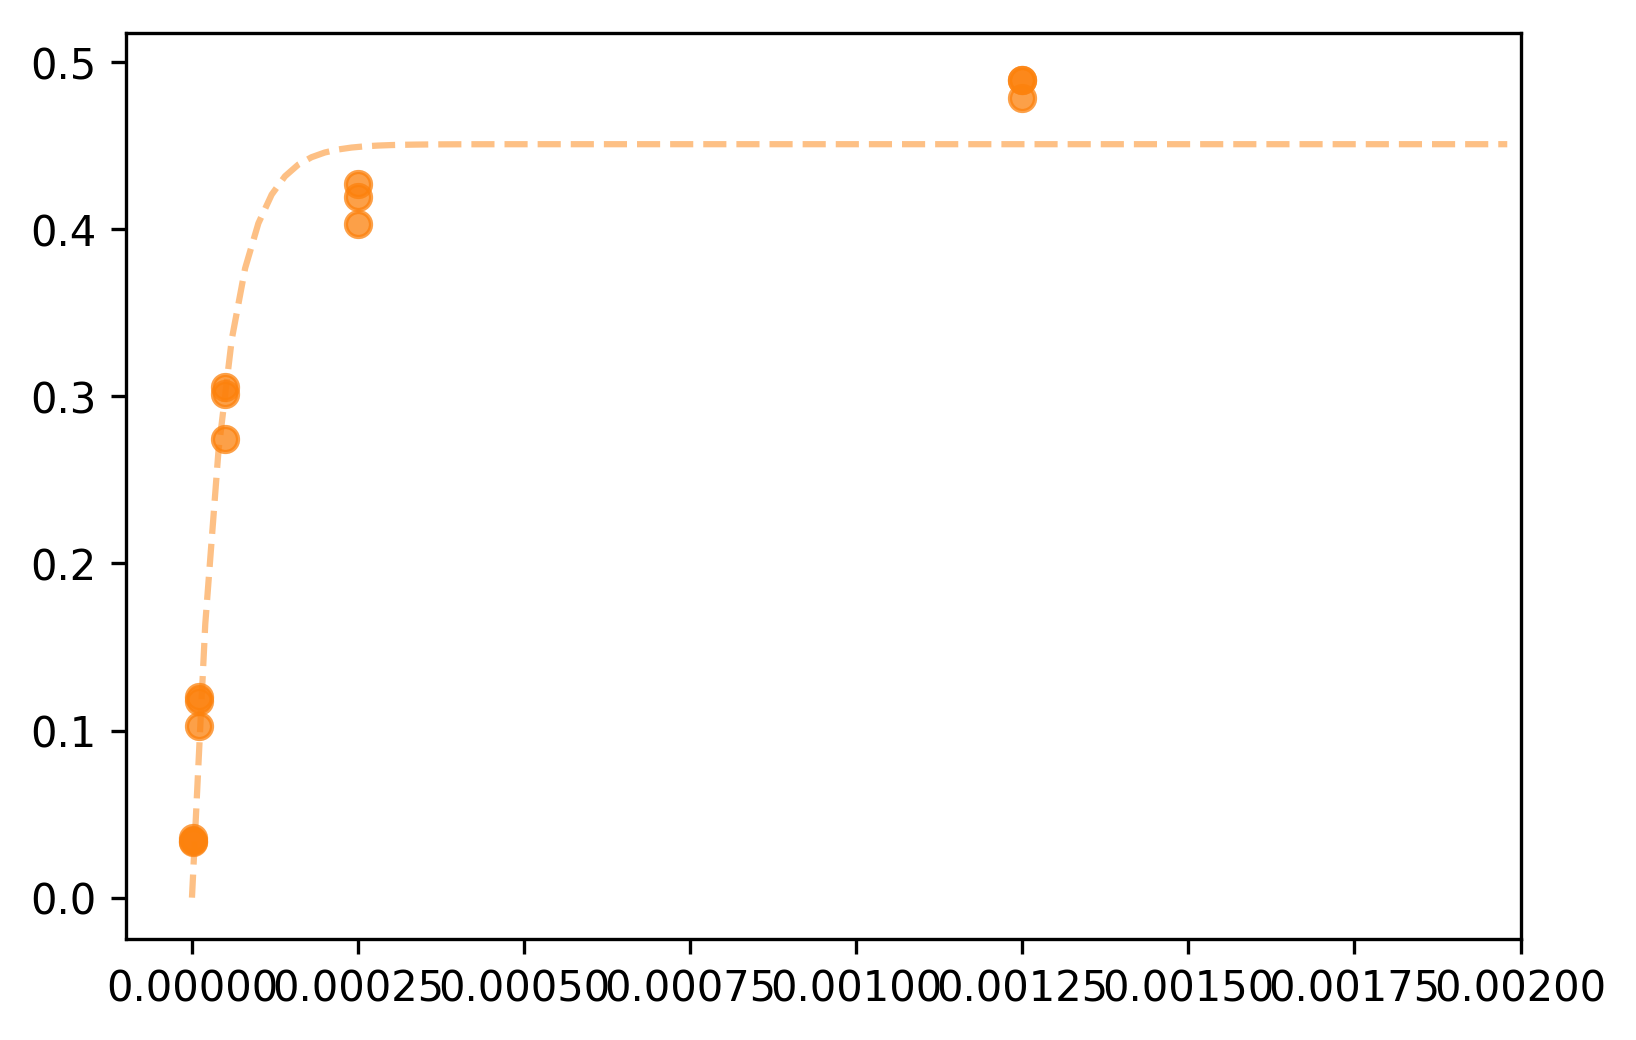

------------------------------S-2.1-t-------------------------------
[0.03653808 0.06642322 0.05916373 0.16115388 0.27364331]
0.11892085016284233  -0.05919790089875334  0.5660214468512264  2.3638209193147097  8.16629898109764
0.03466209333725198  -0.16195094288867035  0.4030104781065264  1.3233779115471427  3.090958633306892
0.04536065781560793  -0.17416669157929715  0.3262915476359354  1.284635583652446  4.152537029126901
0.09971540187152242  -0.1536068311169229  0.48977414358237564  1.9138865719666687  5.426153082851839
0.025274736655821188  -0.22542435323201138  0.4276727832560477  1.885368763524519  5.21561008055406
0.03997887030619839  -0.18930188372268153  0.5139491443446662  2.277192355969403  5.155499886585289


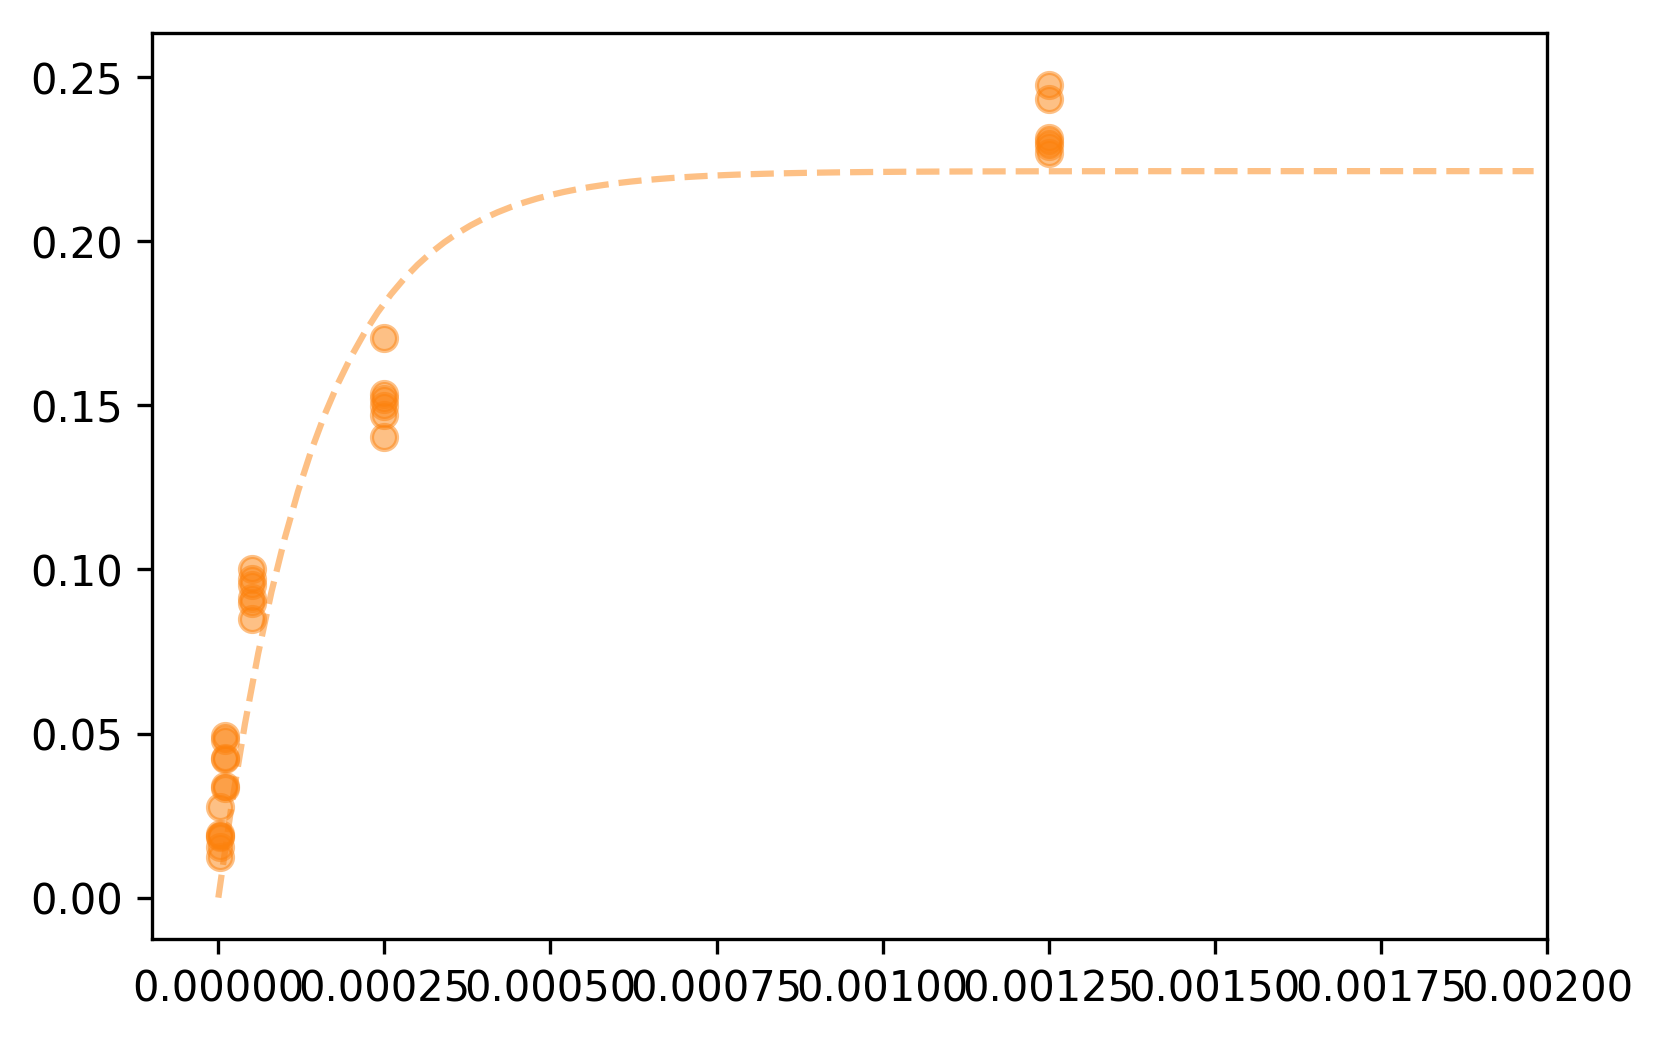

------------------------------S-1A.1-a-------------------------------
[0.02859583 0.06281947 0.29409743 0.51966634 0.54288644]
0.040786545351580515  -0.0007104862720845904  0.6399951403346813  4.308531462757867  21.60102952654809
-0.005132618963261071  -0.11609162974230558  -0.06272082530671609  1.2201530067354758  8.27976728533952
-0.012339477094700419  -0.03173813210581469  0.1286321218403117  1.4314548829256566  8.805959600174537


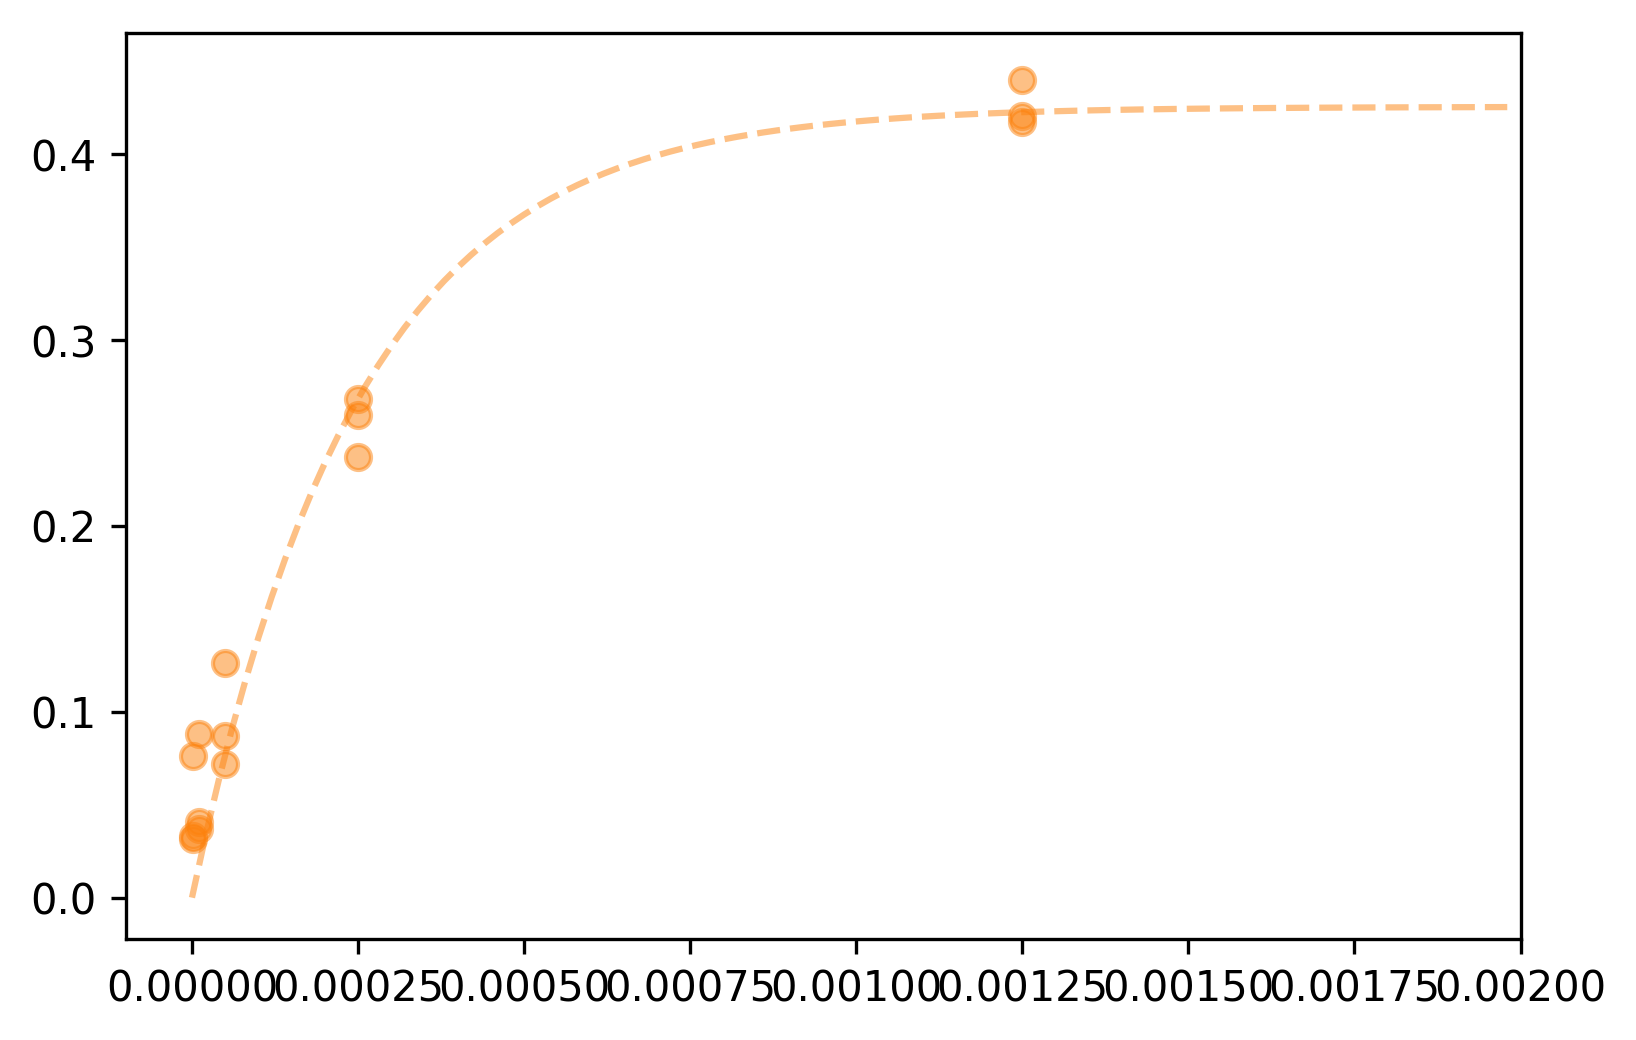

------------------------------S-1B.1-a-------------------------------
[0.15918132 0.28236686 0.27549079 0.05925294 0.66885077]
0.04079777276368118  0.019672257610198002  0.5333149249583198  2.0515059313411874  1.257880614145841
0.13812035311200266  0.21056241397261663  0.4831092670796798  1.7223567553193384  6.909503562832931
-0.17356877846103014  -0.3281681878338364  -0.11137980395744104  1.8155931002749817  11.200988138194155


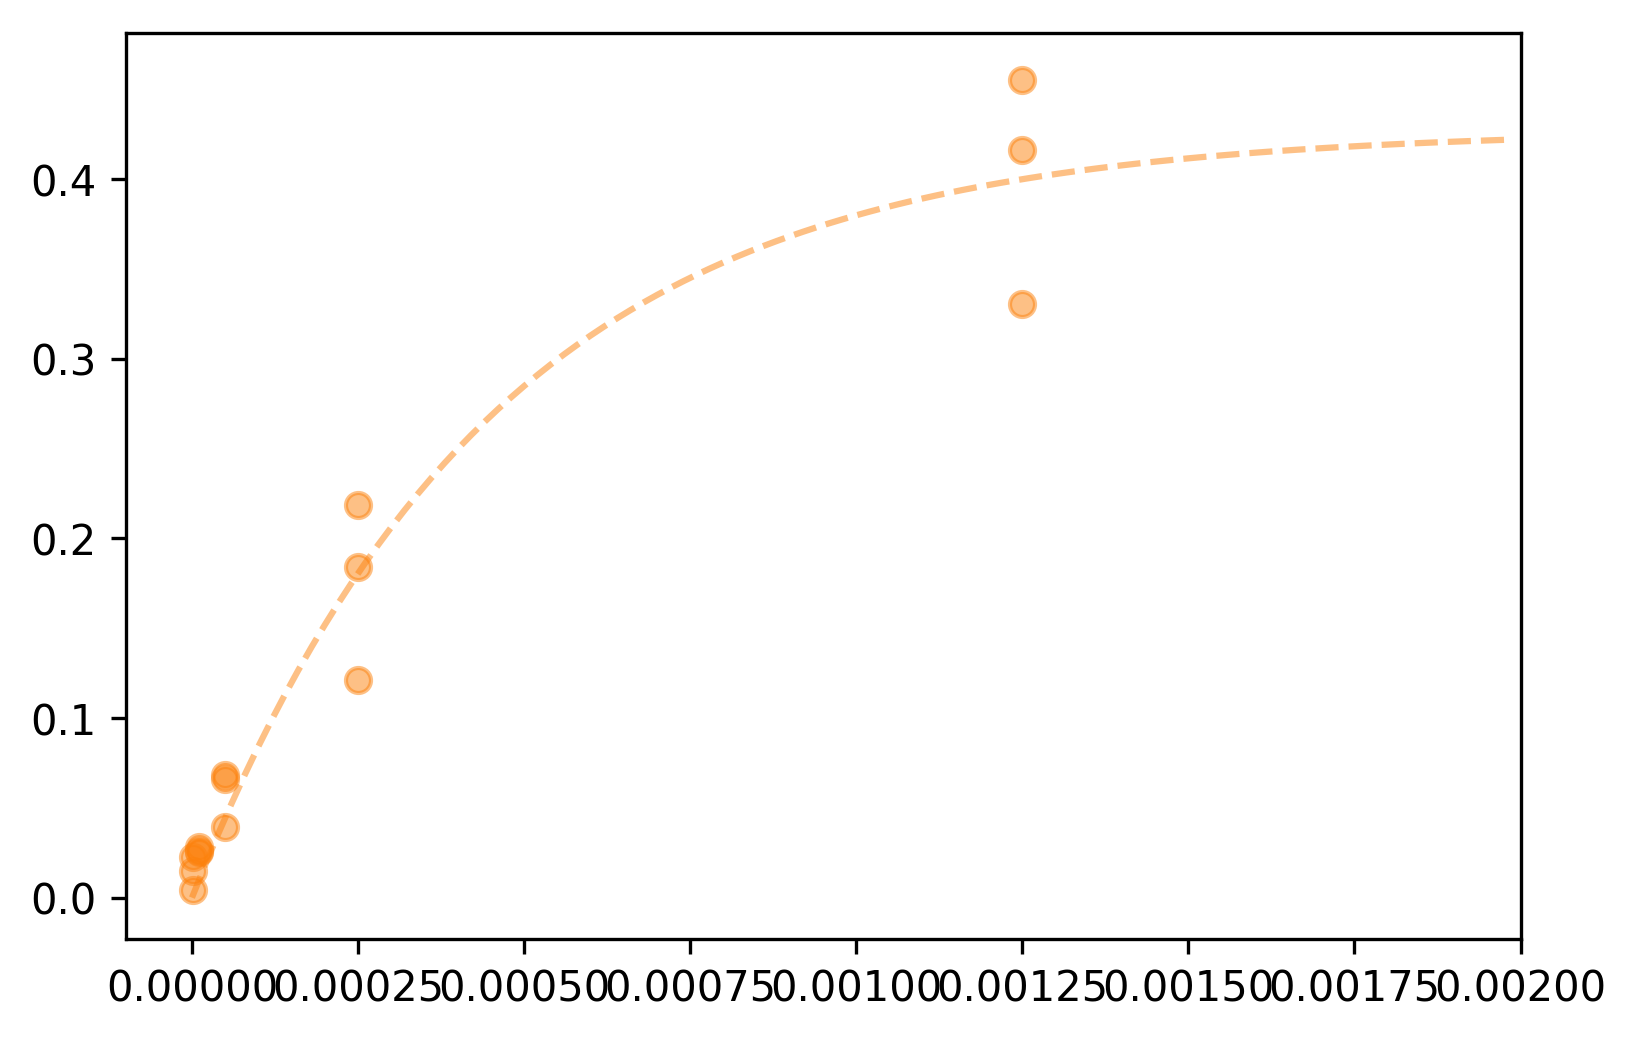

------------------------------S-1B.2-a-------------------------------
[0.19960049 0.28567269 0.16805393 0.21308271 0.28389678]
0.05674374989894209  0.027006032637489998  0.4027488418150345  3.30387530919558  19.105969487064705
0.16789815784565085  0.2076091473395652  0.4386519129458562  1.782478746421287  10.119960939120595
-0.2202518264177663  -0.3346901635365698  0.04491127719605397  2.7245919796374647  15.986641670424273


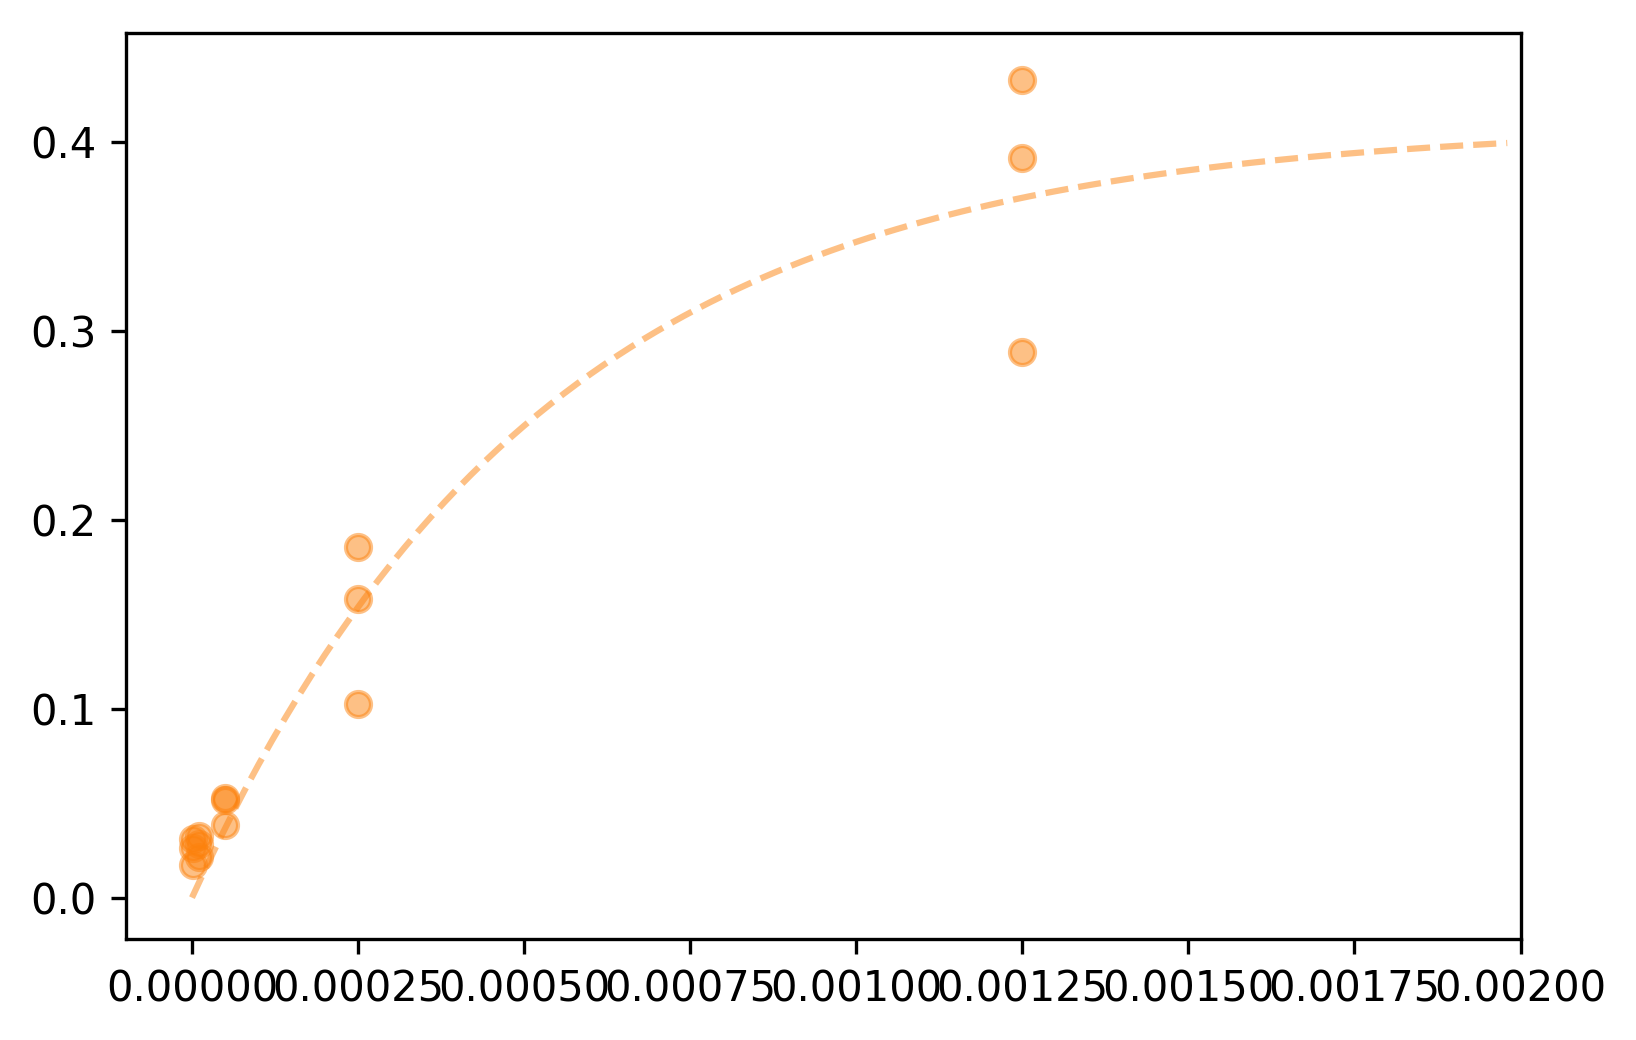

------------------------------S-1B.3-a-------------------------------
[0.16806901 0.29513477 0.2588336  0.160087   0.17032253]
-0.08125876541644107  -0.1688741745864736  0.1145268310714372  1.8207510360284174  10.26777096722902
0.022964086994019757  -0.029474494131514952  0.37199024847591616  1.5004247233441461  6.77818935231517
-0.23836575967105747  -0.44526953706250305  -0.21560261545991455  1.579222701000701  10.262672332461891
0.17313854296690365  0.23101245288279287  0.48942195471519745  2.0240727825202276  9.690842300598595
0.14115081139357144  0.2202417774954238  0.6117694790697776  2.6685835407719396  11.762367440007495


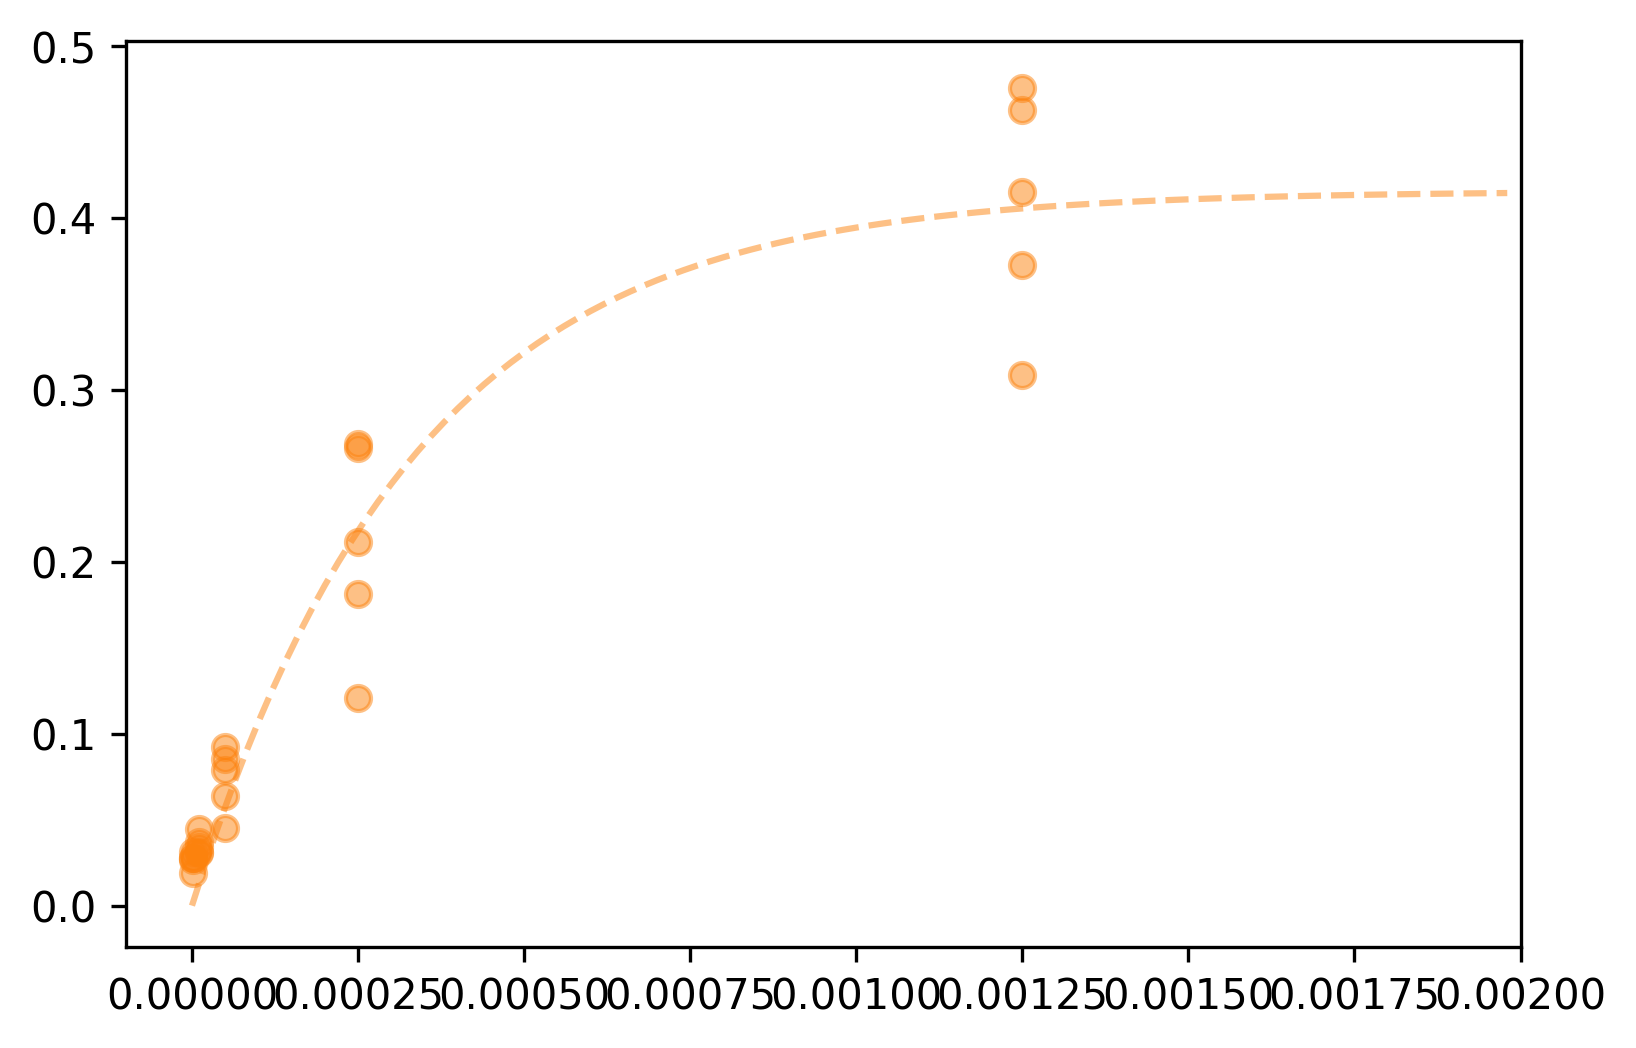

------------------------------S-3.1-a-------------------------------
[0.0531463  0.16461677 0.17109241 0.07267293 0.06041954]
-0.059262884662807346  -0.2114152537482263  -0.02598042264597562  1.2839003161364748  8.131422072663634
0.03645248809848633  0.050511562048375584  0.29078753959219045  1.5101275658589846  7.558059884383681
0.02906561328261958  0.07914469890023916  0.3629683139246217  1.6397054350707507  8.659350098690219


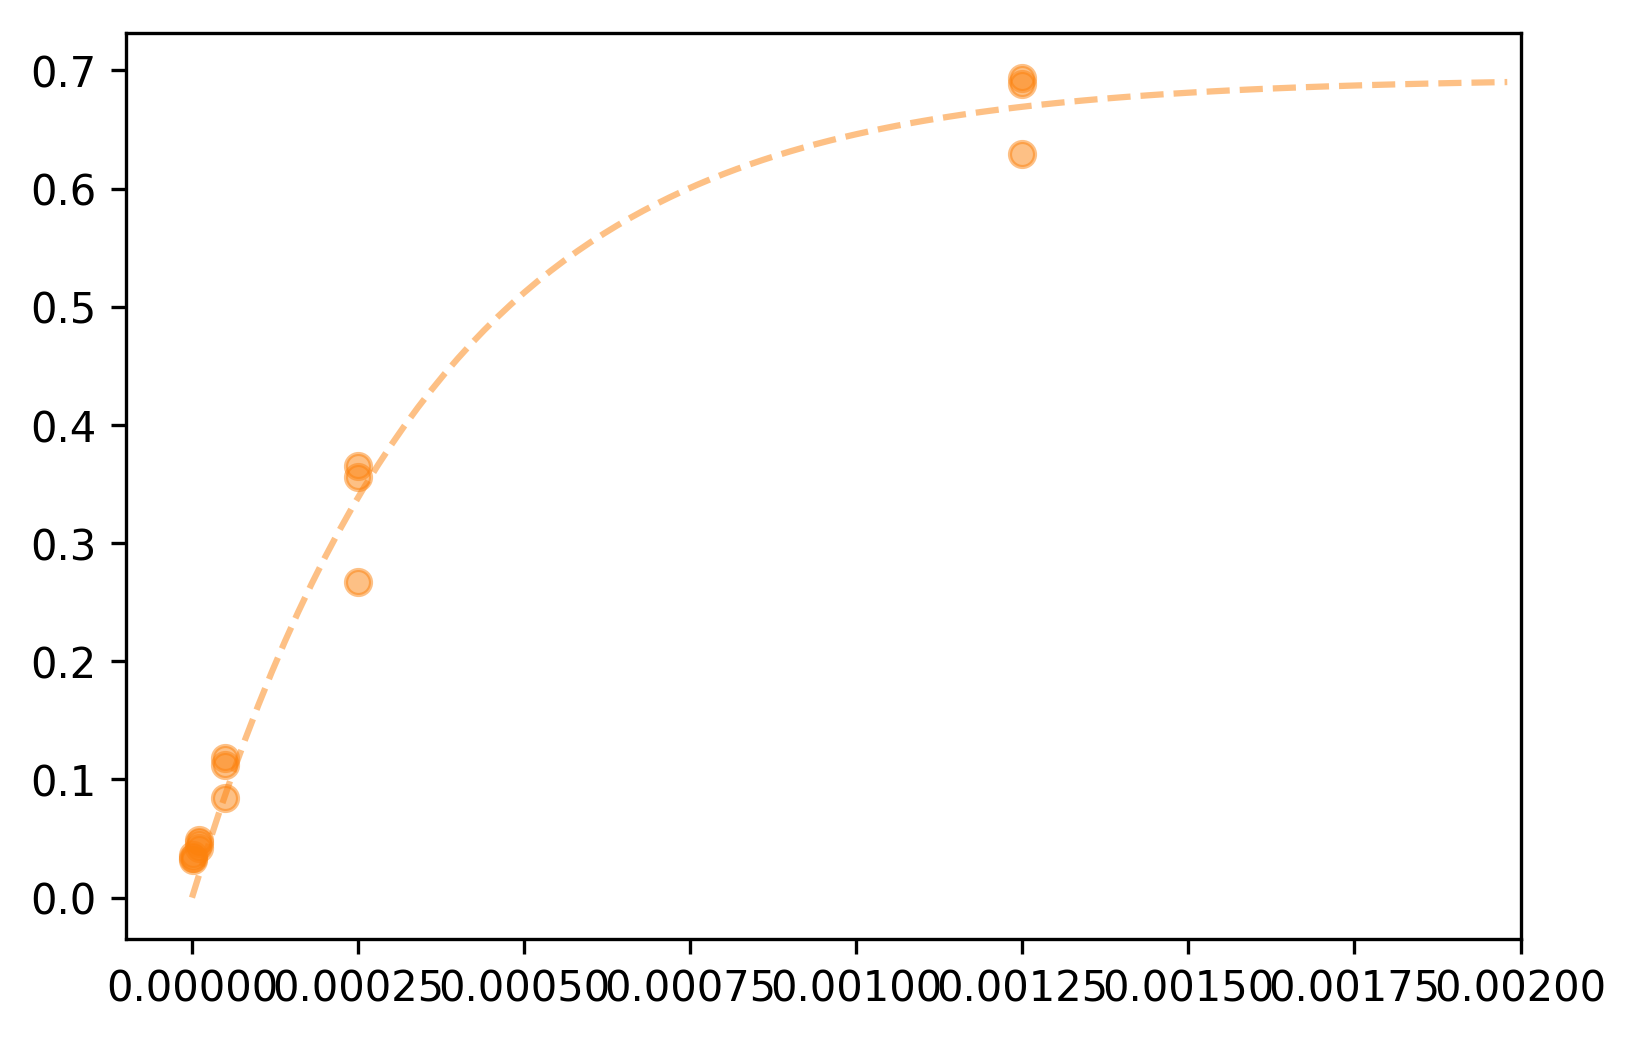

In [248]:
import pprint

for seq in selected_seq.keys():
    print("------------------------------{}-------------------------------".format(seq))
    print(np.std(gel_reacted_frac[seq], axis=0, ddof=1)/np.mean(gel_reacted_frac[seq], axis=0))
    for ix, i in enumerate(selected_seq[seq]['gel_shift_res']['pct_res']):
        if ix%5 == 4:
            print(i)
        else:
            print("{}  ".format(i), end="")
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    plt.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    plt.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params'][:2]), color='#FC820D', ls='--', alpha=0.5)
    plt.xlim([-0.0001, 0.002])
    plt.show()

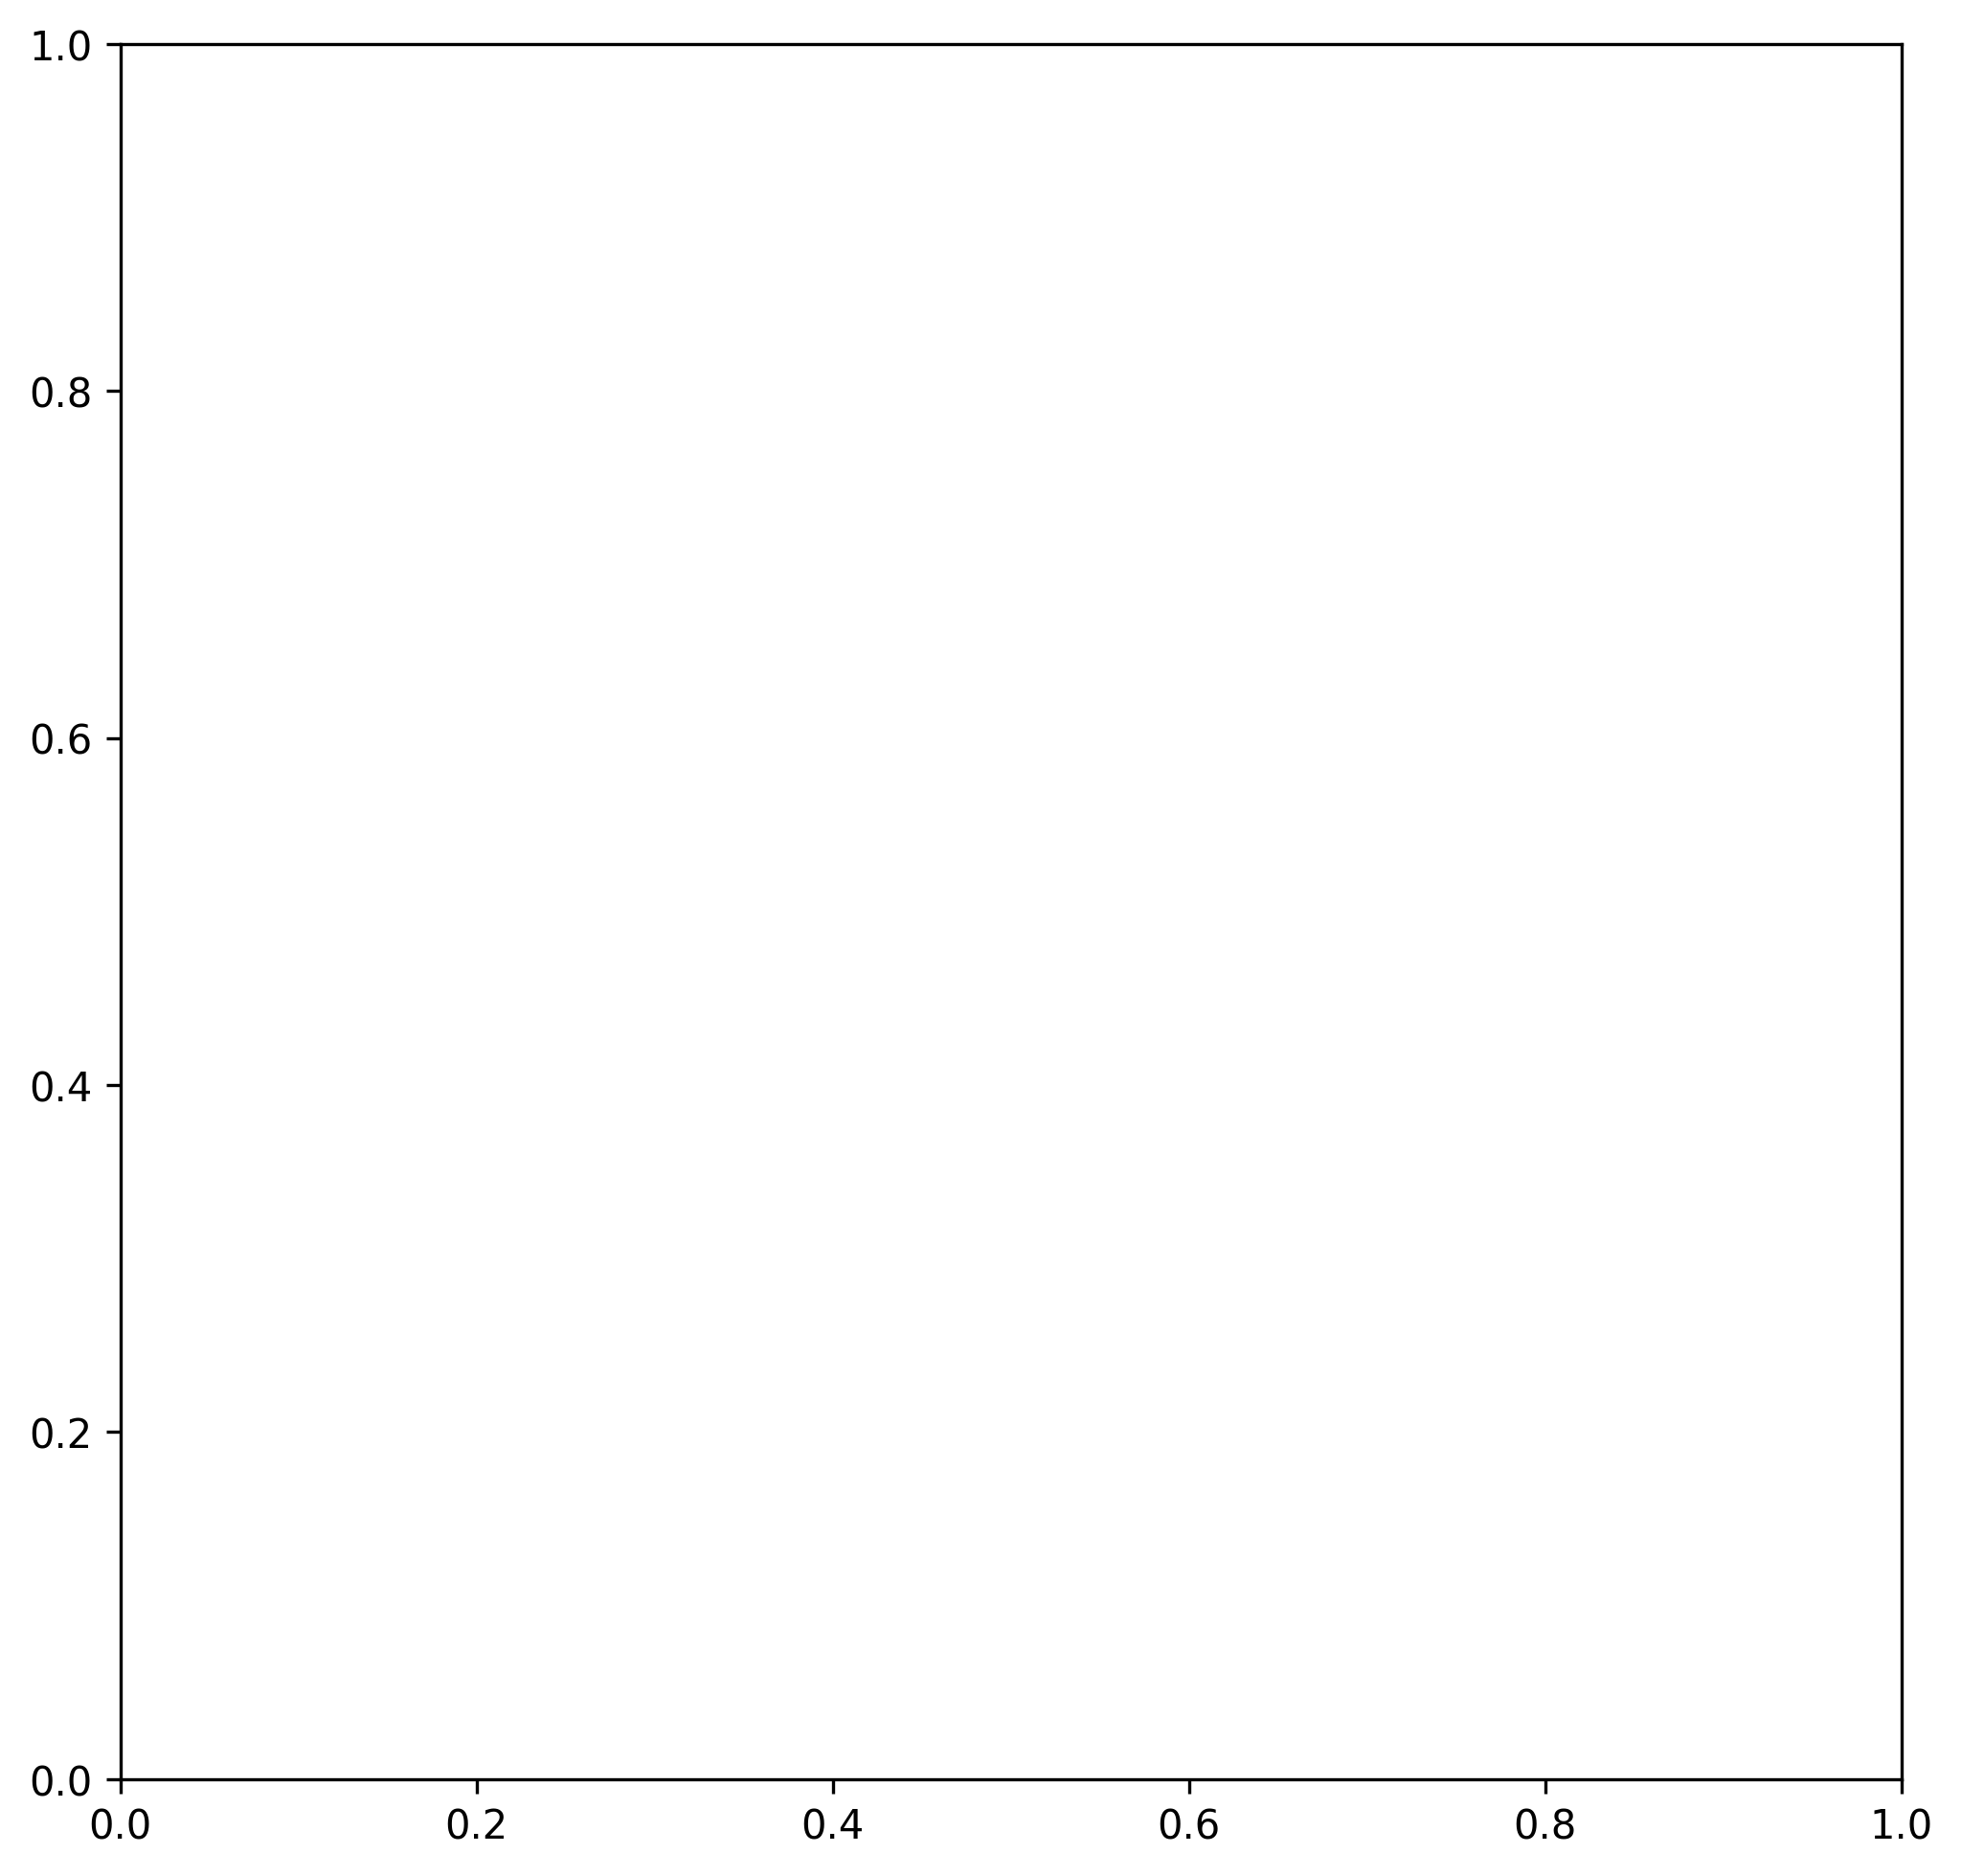

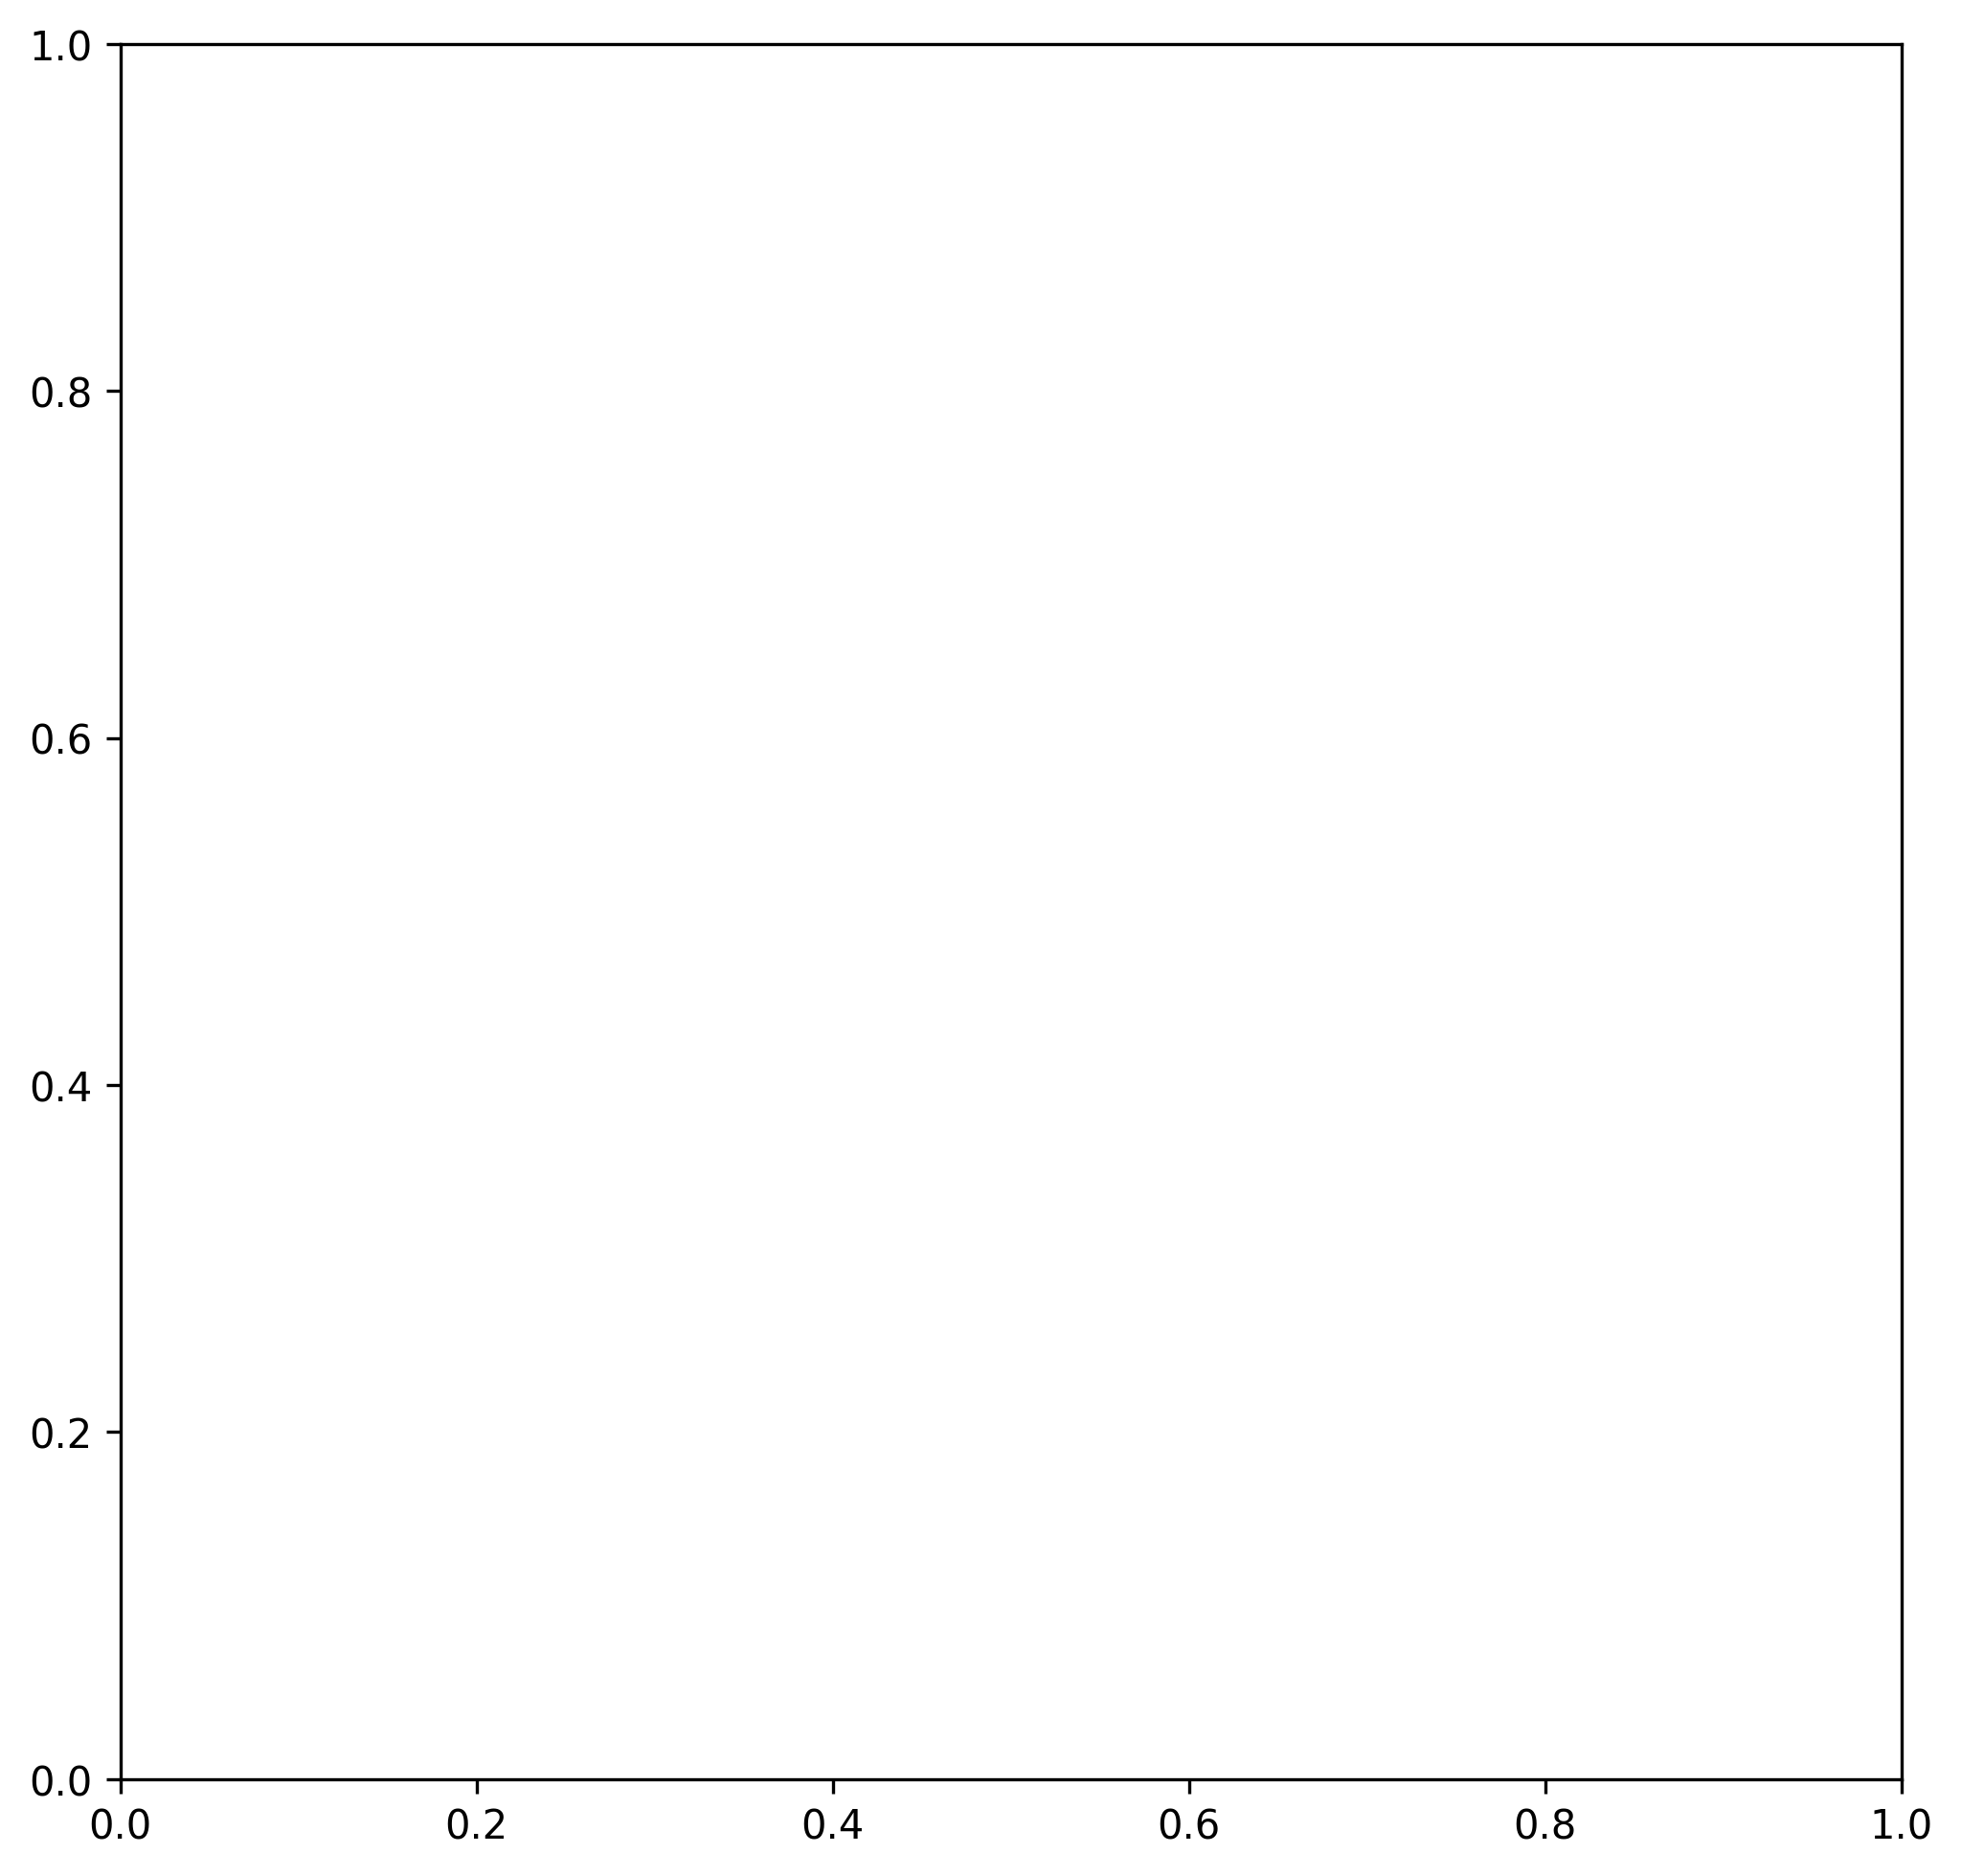

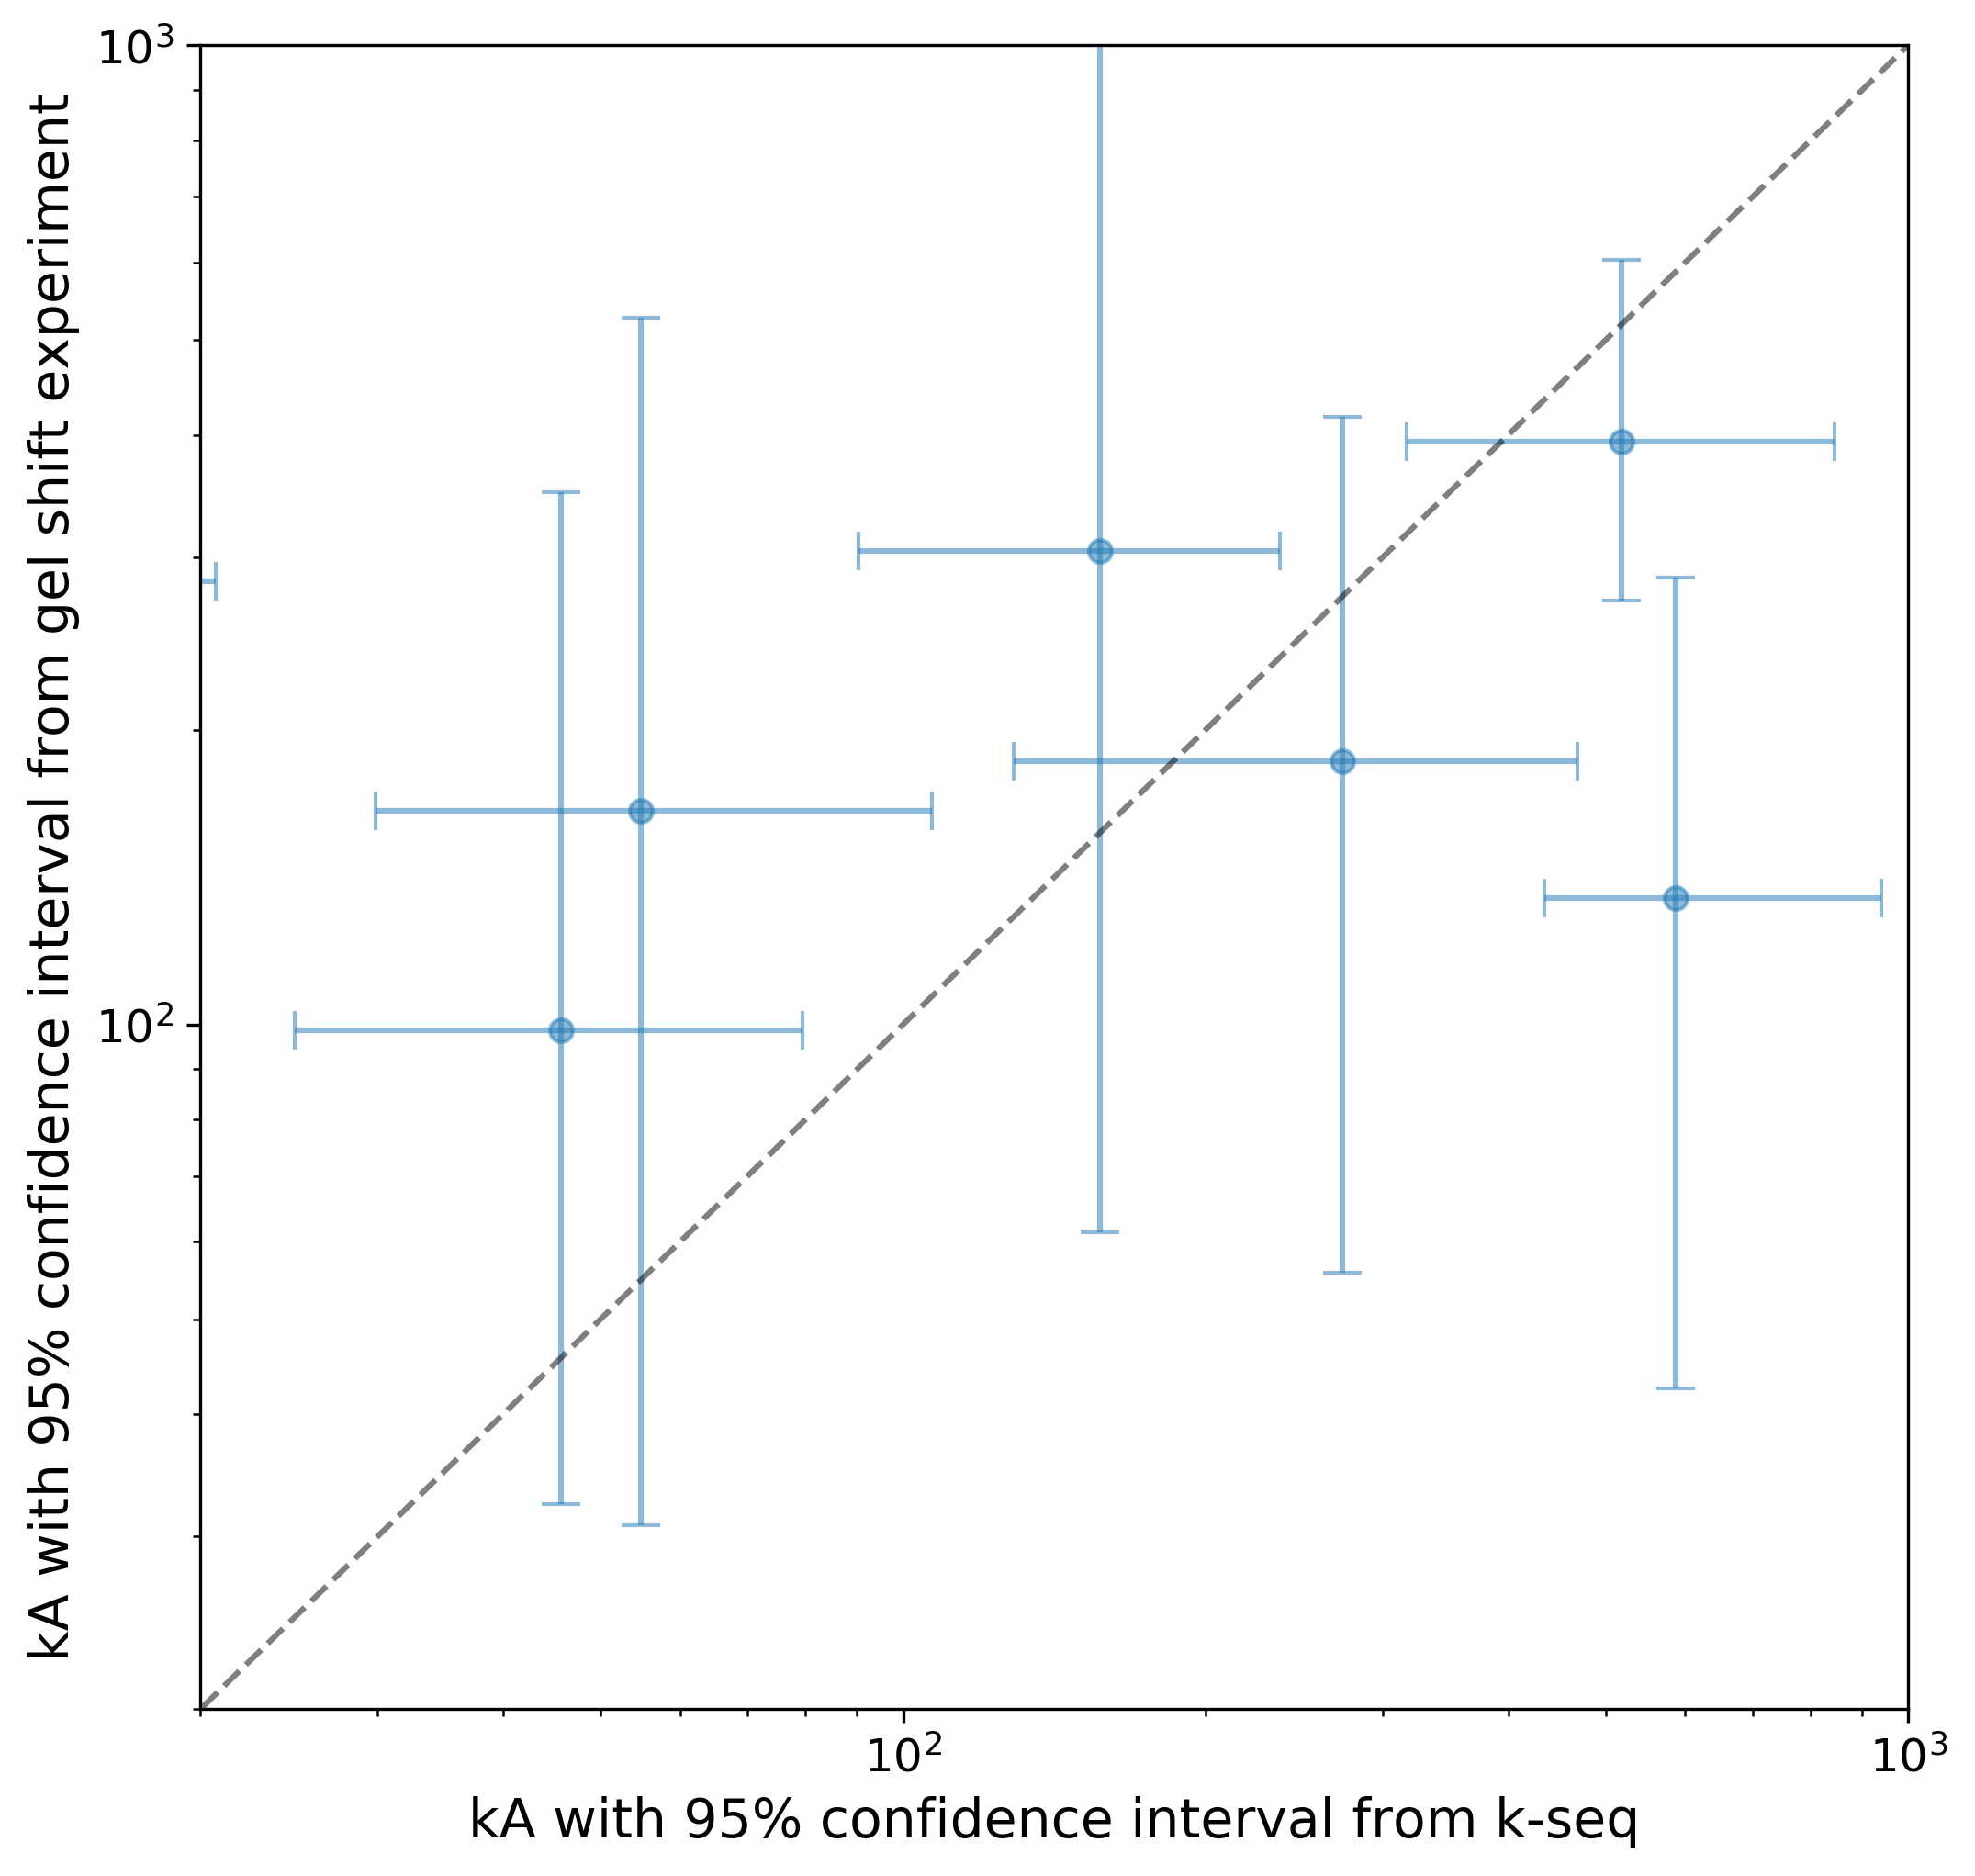

In [224]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=2
reskSeq = [selected_seq[seq]['k_seq_results']['ci95'][param][1] for seq in selected_seq.keys()]
reskSeq95 = [(selected_seq[seq]['k_seq_results']['ci95'][param][1] - selected_seq[seq]['k_seq_results']['ci95'][param][0], selected_seq[seq]['k_seq_results']['ci95'][param][2] - selected_seq[seq]['k_seq_results']['ci95'][param][1]) for seq in selected_seq.keys()]


resGel = [selected_seq[seq]['gel_shift_res']['percentiles']['50'][param] for seq in selected_seq.keys()]
resGel95 = [(selected_seq[seq]['gel_shift_res']['percentiles']['50'][param] - selected_seq[seq]['gel_shift_res']['percentiles']['2.5'][param], selected_seq[seq]['gel_shift_res']['percentiles']['97.5'][param] - selected_seq[seq]['gel_shift_res']['percentiles']['50'][param]) for seq in selected_seq.keys()]

ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()

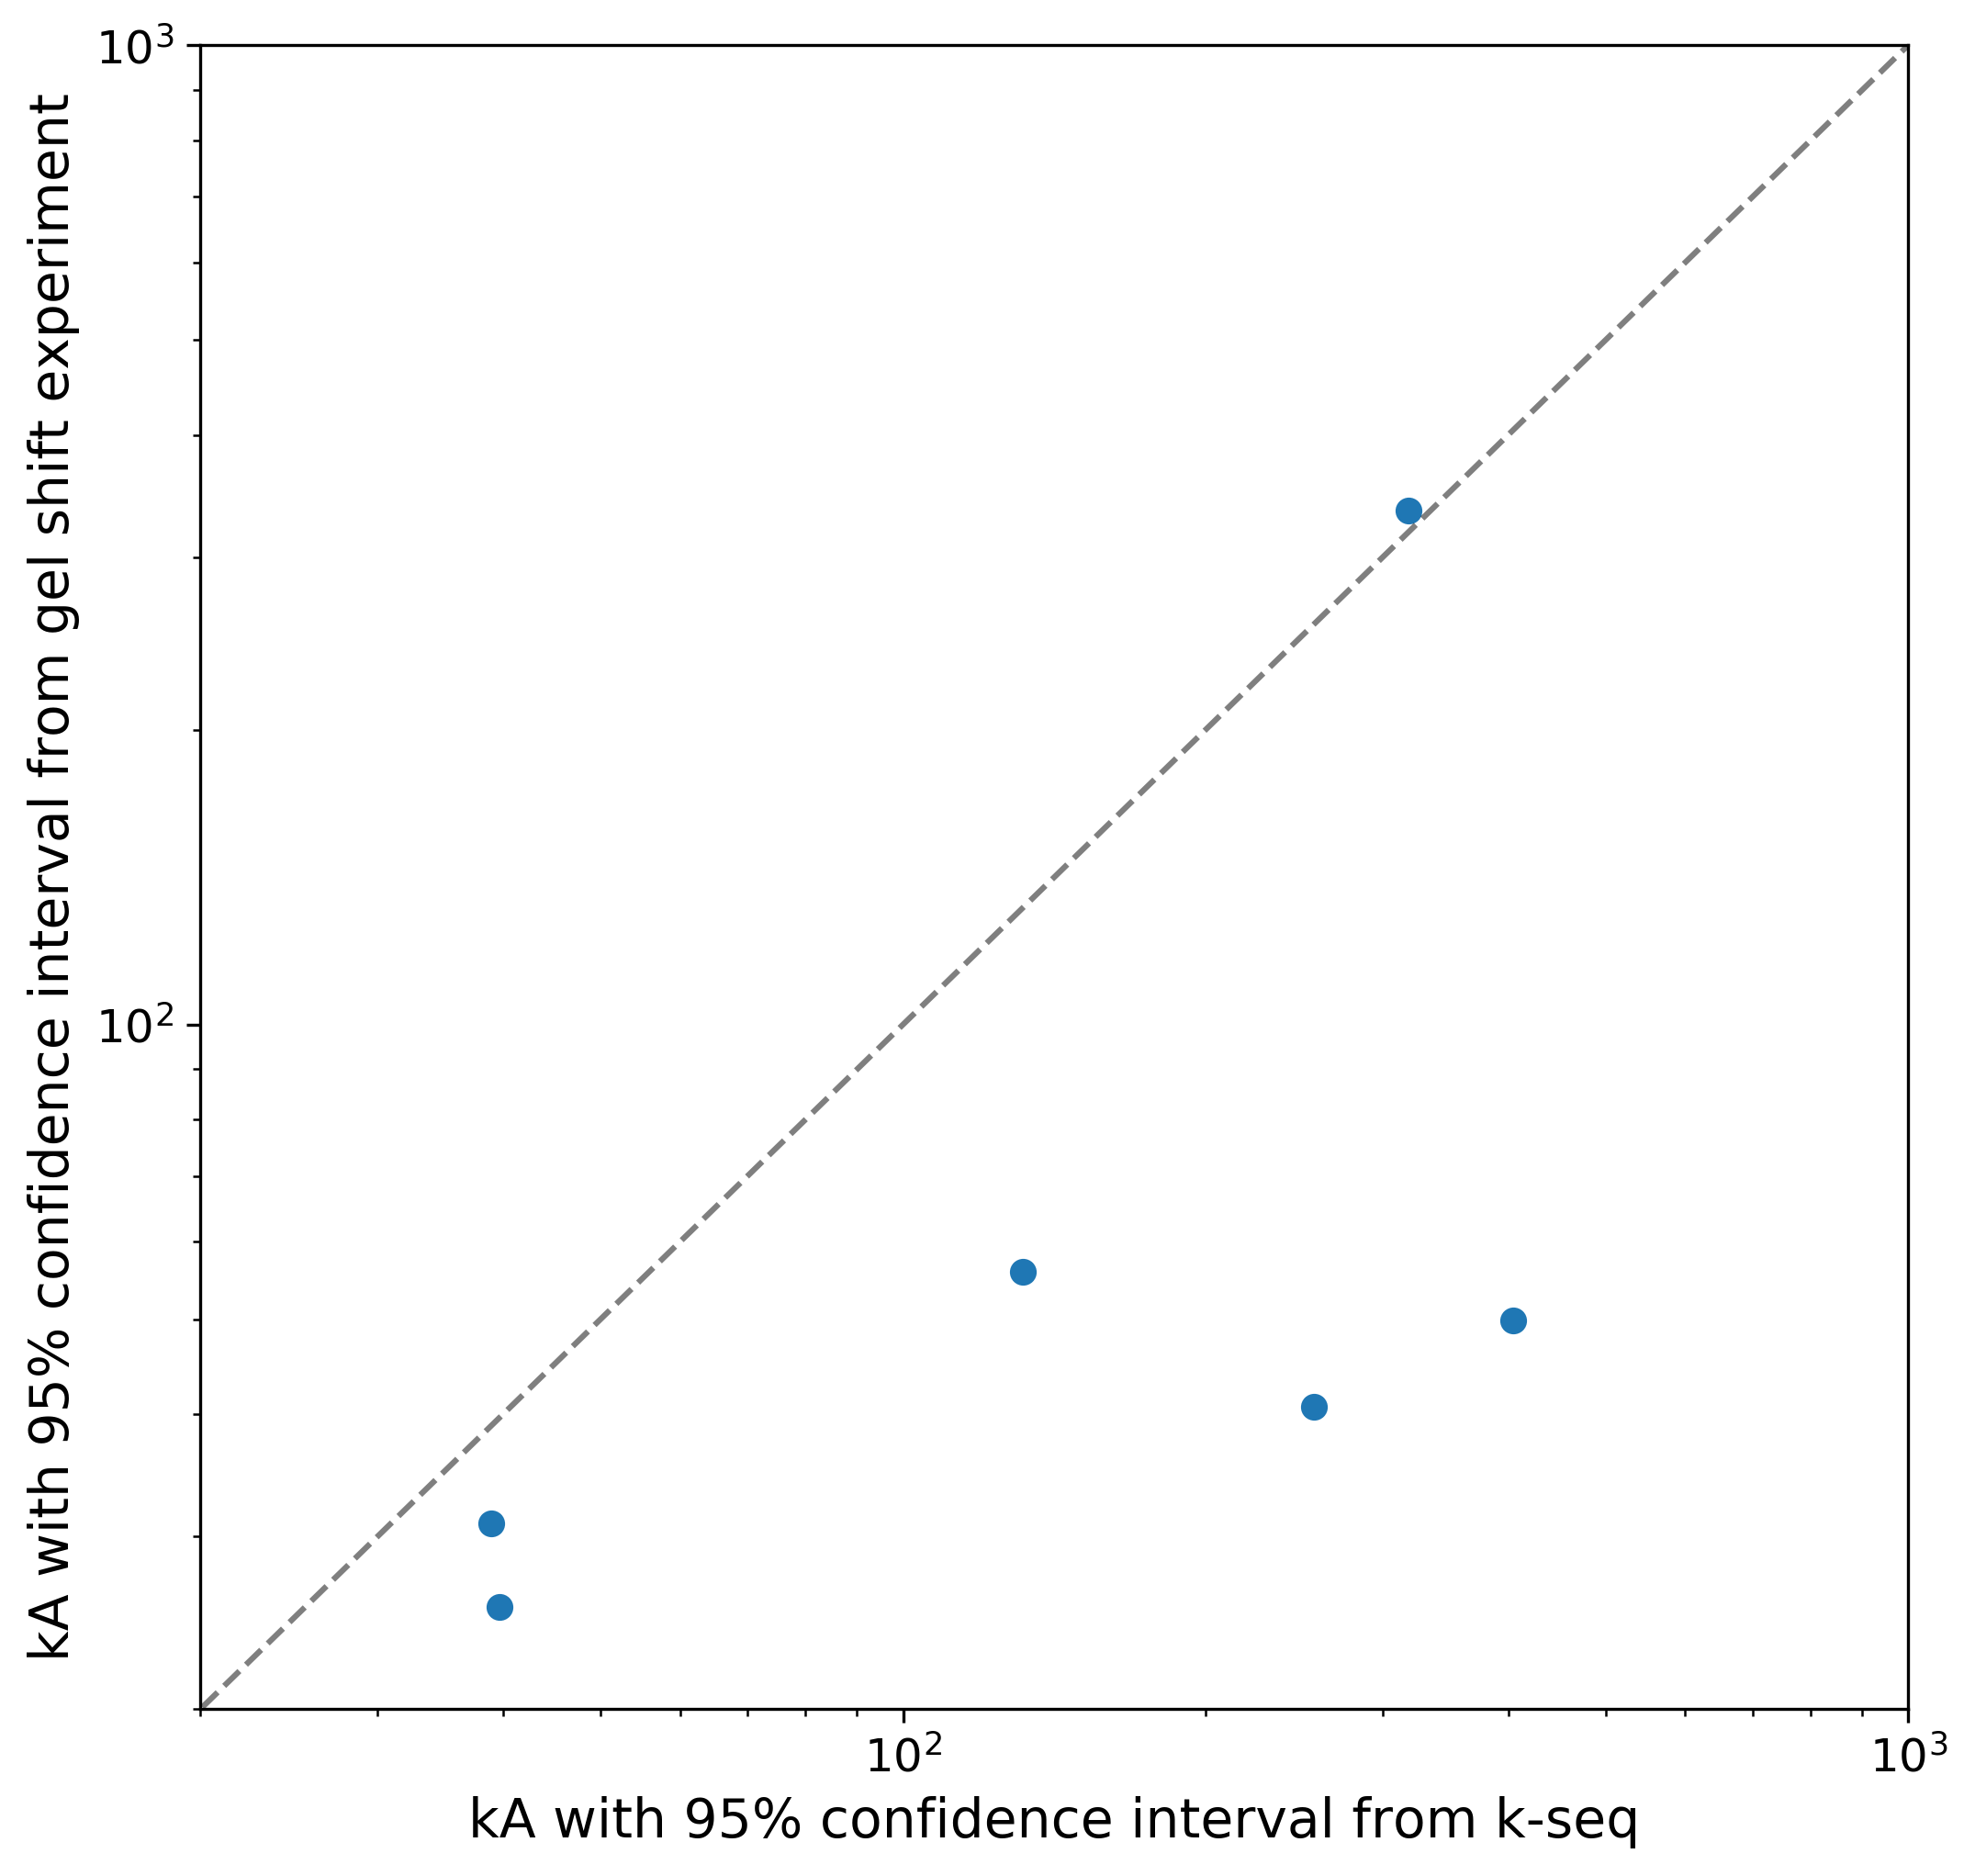

In [235]:
import plot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a * x + b


fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=2
x_k_seq = np.array([selected_seq[seq]['k_seq_results']['params'][param] for seq in selected_seq.keys()])
y_gel = np.array([selected_seq[seq]['gel_shift_res']['params'][param] for seq in selected_seq.keys()])

params, cov = curve_fit(linear_func, x_k_seq, y_gel)

y_hat = linear_func(x_k_seq, *params)
res = y_gel - y_hat
ss_res = np.sum(res ** 2)
ss_tot = np.sum((y_gel - np.mean(y_gel)) ** 2)
r2_0 = (1 - ss_res / ss_tot)


res = y_gel - x_k_seq
ss_res = np.sum(res ** 2)
ss_tot = np.sum((y_gel - np.mean(y_gel)) ** 2)
r2_1 = (1 - ss_res / ss_tot)

res = x_k_seq - y_gel
ss_res = np.sum(res ** 2)
ss_tot = np.sum((x_k_seq - np.mean(x_k_seq)) ** 2)
r2_2 = (1 - ss_res / ss_tot)


ax.scatter(x=x_k_seq, y=y_gel, marker='o')
plot.set_ticks_size(ax)

ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)



plt.show()

In [242]:
print(x_k_seq)
print(y_gel)

[318.12582175 404.83549281 131.56135188  38.91601611  39.64001181
 256.36330122   6.05323921]
[335.0400641   49.83563415  55.90053901  30.92180273  25.41991749
  40.72530348  61.26248913]


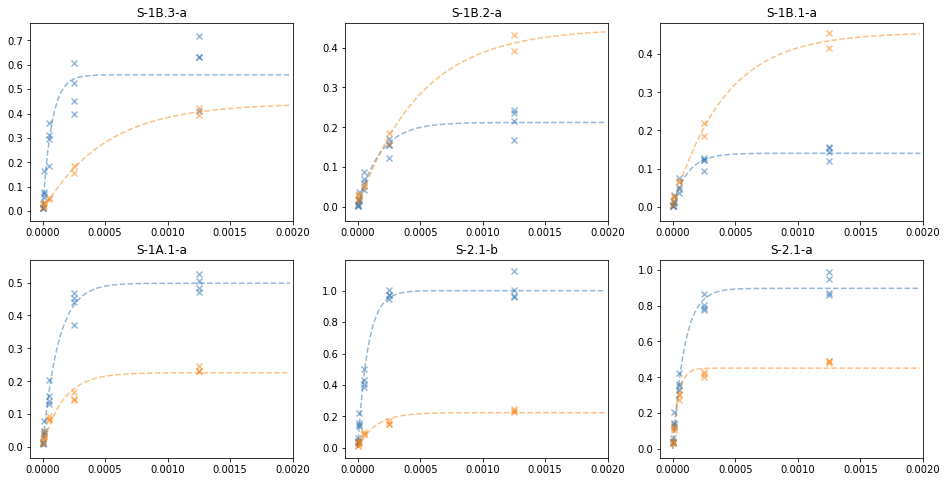

In [337]:
import matplotlib.pyplot as plt

def func(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for ix, seqId in enumerate(seqFinished):
    ax = axes[int(ix/3), ix%3]
    ax.set_title(seqId, fontsize=12)
    ### Plot k-seq data
    x_data = [x_series for _ in range(len(selected_seq[seq]['gel_shift_data']))]
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = np.reshape(
        a=selected_seq[seq]['gel_shift_data'],
        newshape=np.size(selected_seq[seq]['gel_shift_data'])
    )
    ax.scatter(xdata, ydata, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['kSeqRes']['params'][0], selectedSeq[seqId]['kSeqRes']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    ax.scatter(xdata, ydata, marker='x', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['gelRes']['params'][0], selectedSeq[seqId]['gelRes']['params'][1]), color='#FC820D', ls='--', alpha=0.5)

plt.show()

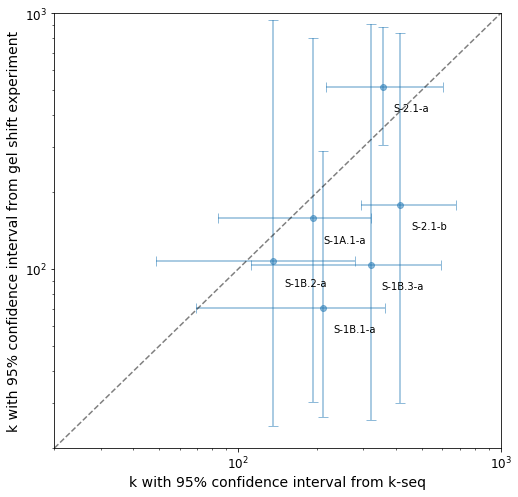

In [373]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=1
reskSeq = [selectedSeq[seqId]['kSeqRes']['ci95'][param][1] for seqId in seqFinished]
reskSeq95 = [(selectedSeq[seqId]['kSeqRes']['ci95'][param][1] - selectedSeq[seqId]['kSeqRes']['ci95'][param][0], selectedSeq[seqId]['kSeqRes']['ci95'][param][2] - selectedSeq[seqId]['kSeqRes']['ci95'][param][1]) for seqId in seqFinished]
resGel = [selectedSeq[seqId]['gelRes']['ci95'][param][1] for seqId in seqFinished]
resGel95 = [(selectedSeq[seqId]['gelRes']['ci95'][param][1] - selectedSeq[seqId]['gelRes']['ci95'][param][0], selectedSeq[seqId]['gelRes']['ci95'][param][2] - selectedSeq[seqId]['gelRes']['ci95'][param][1]) for seqId in seqFinished]
ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

for seqId in seqFinished:
    ax.text(s=seqId, x=selectedSeq[seqId]['kSeqRes']['ci95'][param][1]*1.1, y=selectedSeq[seqId]['gelRes']['ci95'][param][1]*0.8)
ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()

# The rough error correction

In [27]:
import pandas as pd
seqRes = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')
seqRes

,seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
0,AAAAACAAAAACAAA,151,[4 4 4 4 4],1,1,1.000000,123755.179708,123755.179708,129963.510685,138699.361371,146385.826918,138597.222743,1.000000,1.000000,1.000000,1.000000,129963.510685,138699.361371,146385.826918,138597.222743
1,ATTACCCTGGTCATCGAGTT,2,[4 4 4 4 4],1,1,1.000000,2297.589821,2297.589821,3094.024975,7730.971132,11911.680373,7608.926988,1.000000,1.000000,1.000000,1.000000,3094.024975,7730.971132,11911.680373,7608.926988
2,CACCCCGCTTCAAGCAATCGGT,1,[0 0 1 1 0],1,1,0.138958,43192.305540,6001.898690,668.666658,5055.095801,7370.879593,4522.719782,0.128003,0.138958,0.149922,0.141469,4460.087662,38487.154652,53044.093481,32513.867477
3,CCGCTCCAAACAATCGGTCTG,1,[1 0 1 0 0],1,1,0.426227,9098.112658,3877.860461,526.192715,3491.741736,4746.371384,2942.718342,0.409054,0.443400,0.443400,0.430640,1186.722336,8094.744052,11135.785391,6888.272387
4,AAAACAAAAACAAA,4,[4 4 4 4 4],1,1,0.934998,3108.542828,2906.481330,2136.059114,3344.093768,5472.631662,3481.063385,0.870602,1.000000,1.000000,0.978981,2149.704104,3411.891880,5736.717160,3566.128118
5,AAAAACAAAAACAA,1,[4 4 4 4 4],1,1,0.660811,4281.522551,2829.279200,1598.148491,3033.519618,4579.603208,3010.053437,0.554811,0.686282,0.813236,0.687611,2127.419485,4343.537263,7585.463114,4453.953178
6,ATTCCCTGGTCATCGAGTGT,2,[4 4 4 4 4],1,1,1.000000,1356.015769,1356.015769,1421.802558,2606.696101,4707.916719,2747.671672,1.000000,1.000000,1.000000,0.999569,1431.698219,2606.696101,4746.367457,2749.142168
7,AAATTCAAAAACAAAAACAAA,2,[4 3 4 4 4],1,1,1.000000,1003.911278,1003.911278,1468.302610,2583.833720,5003.948320,2794.020806,1.000000,1.000000,1.000000,0.999746,1468.302610,2583.833720,5003.948320,2794.842354
8,ATTACCCT,1,[4 4 4 4 4],1,1,1.000000,1388.450252,1388.450252,1328.299505,2418.582947,4286.776280,2557.514435,1.000000,1.000000,1.000000,0.999460,1328.299505,2419.227833,4286.776280,2558.689602
9,CCCCTTCAATAATCGGTCATG,1,[1 0 1 0 0],1,1,0.281735,9705.618204,2734.416786,327.543407,2311.852435,2971.648974,1899.716078,0.268227,0.281735,0.295244,0.285315,1109.397633,7977.671867,10547.656863,6725.301205


limit_output extension: Maximum message size of 10000 exceeded with 31107 characters

In [ ]:
def seq_err_est_rough(seqList, pErrTotal, pErrLambda):
    """
    A rough method to estimate if a sequence can be possibly come from an error; If yes, label
    """
    
    def get_transition_probability(centerSeq, testSeq, pErrTotal, pErrLambda):
        import Levenshtein
        
        edits = Levenshtein.editops(centerSeq, testSeq)
        d1 = np.sum([1 for edit in edits if edit[0]=='replace'])
        d2 = len(edits) - d1
        return (1-pErrTotal)**len(centerSeq), (pErrLambda*pErrTotal/3)**d1*((1-pErrLambda)pErrTotal/2)**d2*(1-pErrTotal)**(len(centerSeq)-d1-d2)
    
    def test_end(seqList):
        while 
        for seq in seqList.iterrow():
            if pErrTotal**(len(seq['seq'])-1)(1-pErrTotal)*seq['inputCountMedian']:
                
        
        
        
    